## Exploratory Data Analysis and Clinical Table
* Sangwon Baek
* March 10th, 2023

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import kstest, norm, mannwhitneyu, chi2_contingency, fisher_exact, ttest_ind

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, auc
from statsmodels.stats import contingency_tables

pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)

In [2]:
#Read csv file using pandas
df = pd.read_csv('../Data/Preprocessed/CRF_Optimal.csv', low_memory=False)
df = df.drop(columns='Unnamed: 0')
df1 = pd.read_csv('../Data/Preprocessed/CRF_ALL_included.csv', low_memory=False)
df1 = df1.drop(columns='Unnamed: 0')
df2 = pd.read_csv('../Data/Preprocessed/CRF_Initial.csv', low_memory=False)
df2 = df2.drop(columns='Unnamed: 0')
df3 = pd.read_csv('../Data/Preprocessed/CRF_DDLDH_removed.csv', low_memory=False)
df3 = df3.drop(columns='Unnamed: 0')

In [3]:
na_cols = ['UD_HT','UD_DM','UD_CVD','UD_cancer','UD_other','SMT_fever','SMT_cough','SMT_sputum','SMT_dyspnea',
          'SMT_myalgia', 'SMT_sorethroat', 'SMT_mental', 'SMT_GI', 'steroid']
df1[na_cols] = df1[na_cols].fillna(value=0)
df2[na_cols] = df2[na_cols].fillna(value=0)
df3[na_cols] = df3[na_cols].fillna(value=0)

In [4]:
ColumnNames = ['No', 'ID', 'age', 'sex', 'dx_date', 'hospitalized_date', 'UD_HT', 'UD_DM', 'UD_CVD', 'UD_cancer',
              'UD_other', 'SMT_fever', 'SMT_cough', 'SMT_sputum', 'SMT_dyspnea', 'SMT_myalgia',
              'SMT_sorethroat', 'SMT_mental', 'SMT_GI', 'TX_0', 'TX_1', 'TX_2', 'TX_3', 'TX_4', 
               'Smoking_0', 'Smoking_1', 'Smoking_2', 'Smoking_3', 'BT', 'SBP', 
               'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH', 'DD', 'PCR', 
               'steroid', 'Mild','Moderate','Severe', 'ventilator', 'ECMO', 'ICU_date', 'Mortality']
df = df[ColumnNames]
df1 = df1[ColumnNames]
df2 = df2[ColumnNames].drop(columns = 'DD')
df3 = df3[ColumnNames].drop(columns = ['DD', 'LDH'])

In [5]:
# Replace 'UD_' and 'SMT_' in the column names
new_column_names = {col: col.replace('UD_', '').replace('SMT_', '') for col in df2.columns}

# Rename the columns in the dataframe
df2 = df2.rename(columns=new_column_names)

In [6]:
#Create additional column to indicate Validation set: 0 or Development set: 1
df['DevVal'] = np.where(df['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU']), 0, 1)
df1['DevVal'] = np.where(df1['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU']), 0, 1)
df2['DevVal'] = np.where(df2['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU']), 0, 1)
df3['DevVal'] = np.where(df3['ID'].isin(['SCH', 'SCN' 'SMC', 'JNU']), 0, 1)


In [7]:
#Running a Kolmogorov-Smirnov test (KS test) to check the normality of the distribution
#When the p-value is <0.01, we can reject the null hypothesis of normality: meaning the distribution is not normal. Then, use median & IQR 
testingCol_ALL = ['age', 'BT', 'SBP', 'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH', 'DD']
testingCol_DD_R = ['age', 'BT', 'SBP', 'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH']
testingCol_DDLDH_R = ['age', 'BT', 'SBP', 'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP']

def ksTester(df, col):
    for item in col:
        if item in df.columns:
            stats, pval = kstest(df[item], norm.cdf)
        print("{} _stats: {:.5F}".format(item, stats))
        print("{} _pvalue: {:.5F}".format(item, pval))
# ksTester(df, testingCol)
# ksTester(df1, testingCol_ALL)
# ksTester(df2, testingCol_DD_R)
# ksTester(df3, testingCol)

### Missing Value Percentages

In [8]:
items = ['UD_HT', 'UD_DM', 'UD_CVD', 'UD_cancer','UD_other', 'SMT_fever', 'SMT_cough', 'SMT_sputum', 'SMT_dyspnea', 'SMT_myalgia',
         'SMT_sorethroat', 'SMT_mental', 'SMT_GI','BT', 'SBP', 'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'PCR', 'steroid', 'LDH', 'DD']
for item in items:
    missing = df[item].notnull().sum()/len(df)*100
    print("{} N/A Percent: {:.2F}%".format(item, missing))

UD_HT N/A Percent: 96.85%
UD_DM N/A Percent: 96.32%
UD_CVD N/A Percent: 95.59%
UD_cancer N/A Percent: 95.53%
UD_other N/A Percent: 84.16%
SMT_fever N/A Percent: 96.22%
SMT_cough N/A Percent: 95.87%
SMT_sputum N/A Percent: 95.67%
SMT_dyspnea N/A Percent: 96.41%
SMT_myalgia N/A Percent: 95.21%
SMT_sorethroat N/A Percent: 95.21%
SMT_mental N/A Percent: 89.00%
SMT_GI N/A Percent: 90.44%
BT N/A Percent: 89.97%
SBP N/A Percent: 89.67%
DBP N/A Percent: 89.67%
PR N/A Percent: 89.59%
RR N/A Percent: 89.41%
SPO2 N/A Percent: 92.95%
WBC N/A Percent: 84.70%
ANC N/A Percent: 94.79%
ALC N/A Percent: 94.80%
PLT N/A Percent: 95.08%
CRP N/A Percent: 94.45%
PCR N/A Percent: 100.00%
steroid N/A Percent: 94.91%
LDH N/A Percent: 82.18%
DD N/A Percent: 52.51%


### Distribution Bar/Density Plot

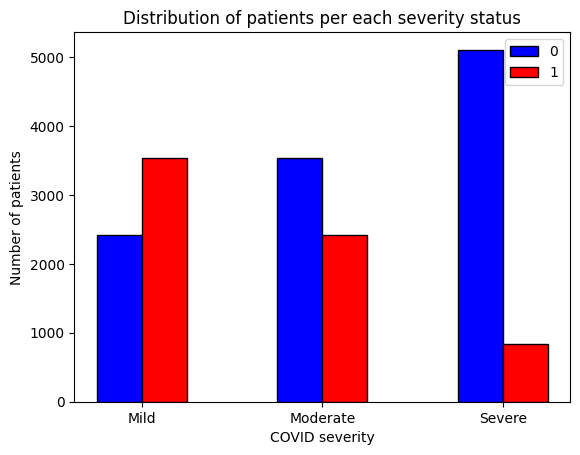

In [9]:
N_cases = [df2['Mild'].value_counts()[0], df2['Moderate'].value_counts()[0], df2['Severe'].value_counts()[0]]
P_cases = [df2['Mild'].value_counts()[1], df2['Moderate'].value_counts()[1], df2['Severe'].value_counts()[1]]
plt.bar(np.arange(3), N_cases, color='b', width=0.25, edgecolor='black',label='0')
plt.bar(np.arange(3)+0.25, P_cases, color='r', width=0.25, edgecolor='black',label='1')
plt.xlabel("COVID severity")
plt.ylabel("Number of patients")
plt.title("Distribution of patients per each severity status")
plt.xticks(np.arange(3)+0.25/2,['Mild','Moderate','Severe'])
plt.legend()
plt.show()

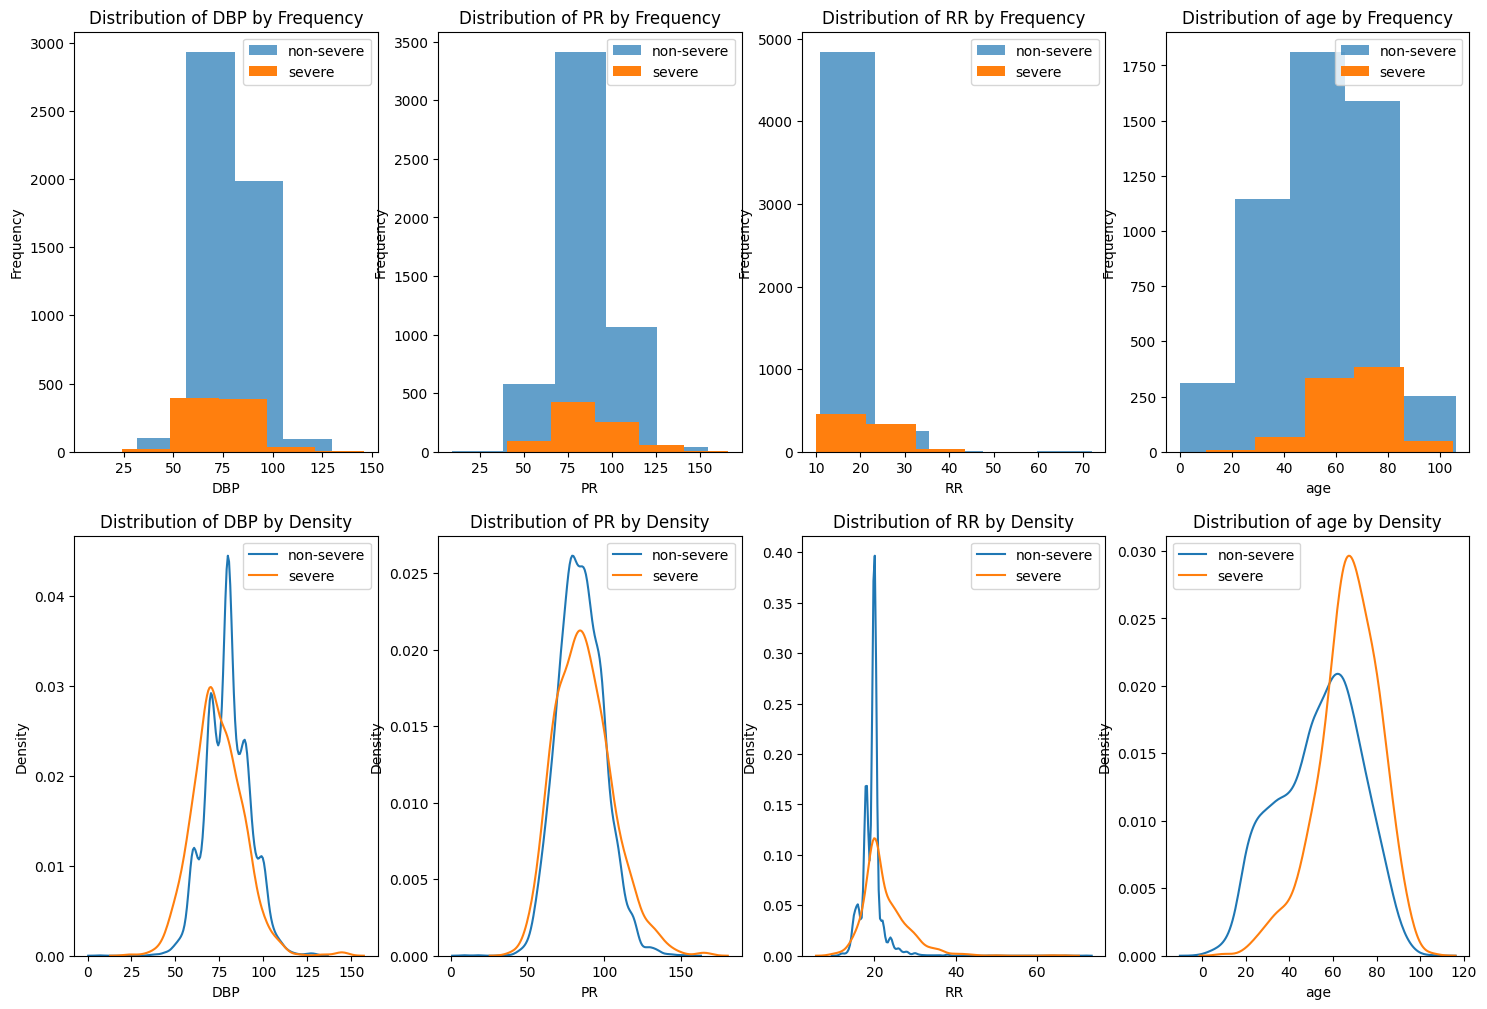

In [10]:
# seeing distributions of Testing Col features by TARGET value

# plotting histograms
testing_source = df2[['DBP', 'PR', 'RR', 'age']]
titles = list(enumerate(testing_source))

fig, axs = plt.subplots(2, testing_source.shape[1], figsize = (18,12))
for row in range(2):
    for i, feature in enumerate(testing_source):
        if row == 0:
            # by frequency
            axs[row,i].hist(testing_source[df2['Severe'] == 0][feature], bins = 5, label = 'non-severe', alpha = 0.7)
            axs[row,i].hist(testing_source[df2['Severe'] == 1][feature], bins = 5, label = "severe")
            axs[row,i].legend(loc='best')
            axs[row,i].set(title = 'Distribution of '+ titles[i][1] + ' by Frequency', xlabel = titles[i][1], ylabel = 'Frequency')
        else:
            # by density
            sns.kdeplot(testing_source[df2['Severe'] == 0][feature], label = 'non-severe', ax = axs[row,i])
            sns.kdeplot(testing_source[df2['Severe'] == 1][feature], label = "severe", ax = axs[row,i])
            axs[row,i].legend(loc='best')
            axs[row,i].set(title = 'Distribution of '+ titles[i][1] + ' by Density', xlabel = titles[i][1], ylabel = 'Density')
plt.show()

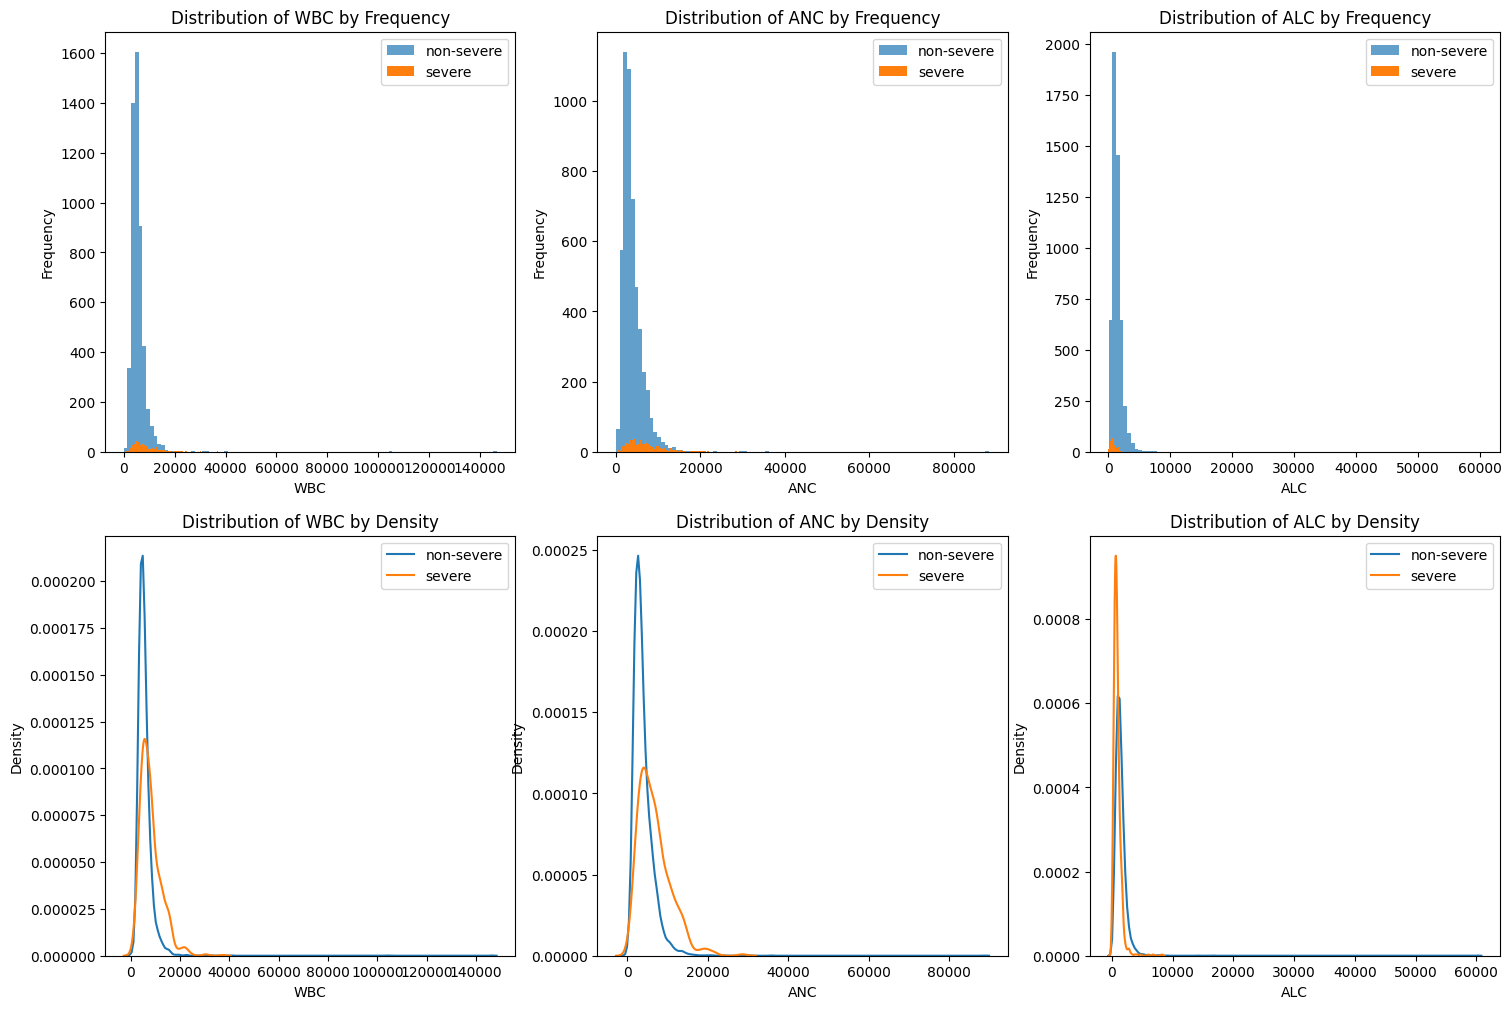

In [11]:
# seeing distributions of Testing Col features by TARGET value

# plotting histograms
testing_source = df2[['WBC', 'ANC', 'ALC']]
titles = list(enumerate(testing_source))

fig, axs = plt.subplots(2, testing_source.shape[1], figsize = (18,12))
for row in range(2):
    for i, feature in enumerate(testing_source):
        if row == 0:
            # by frequency
            axs[row,i].hist(testing_source[df2['Severe'] == 0][feature], bins = 100, label = 'non-severe', alpha = 0.7)
            axs[row,i].hist(testing_source[df2['Severe'] == 1][feature], bins = 100, label = "severe")
            axs[row,i].legend(loc='best')
            axs[row,i].set(title = 'Distribution of '+ titles[i][1] + ' by Frequency', xlabel = titles[i][1], ylabel = 'Frequency')
        else:
            # by density
            sns.kdeplot(testing_source[df2['Severe'] == 0][feature], label = 'non-severe', ax = axs[row,i])
            sns.kdeplot(testing_source[df2['Severe'] == 1][feature], label = "severe", ax = axs[row,i])
            axs[row,i].legend(loc='best')
            axs[row,i].set(title = 'Distribution of '+ titles[i][1] + ' by Density', xlabel = titles[i][1], ylabel = 'Density')
plt.show()

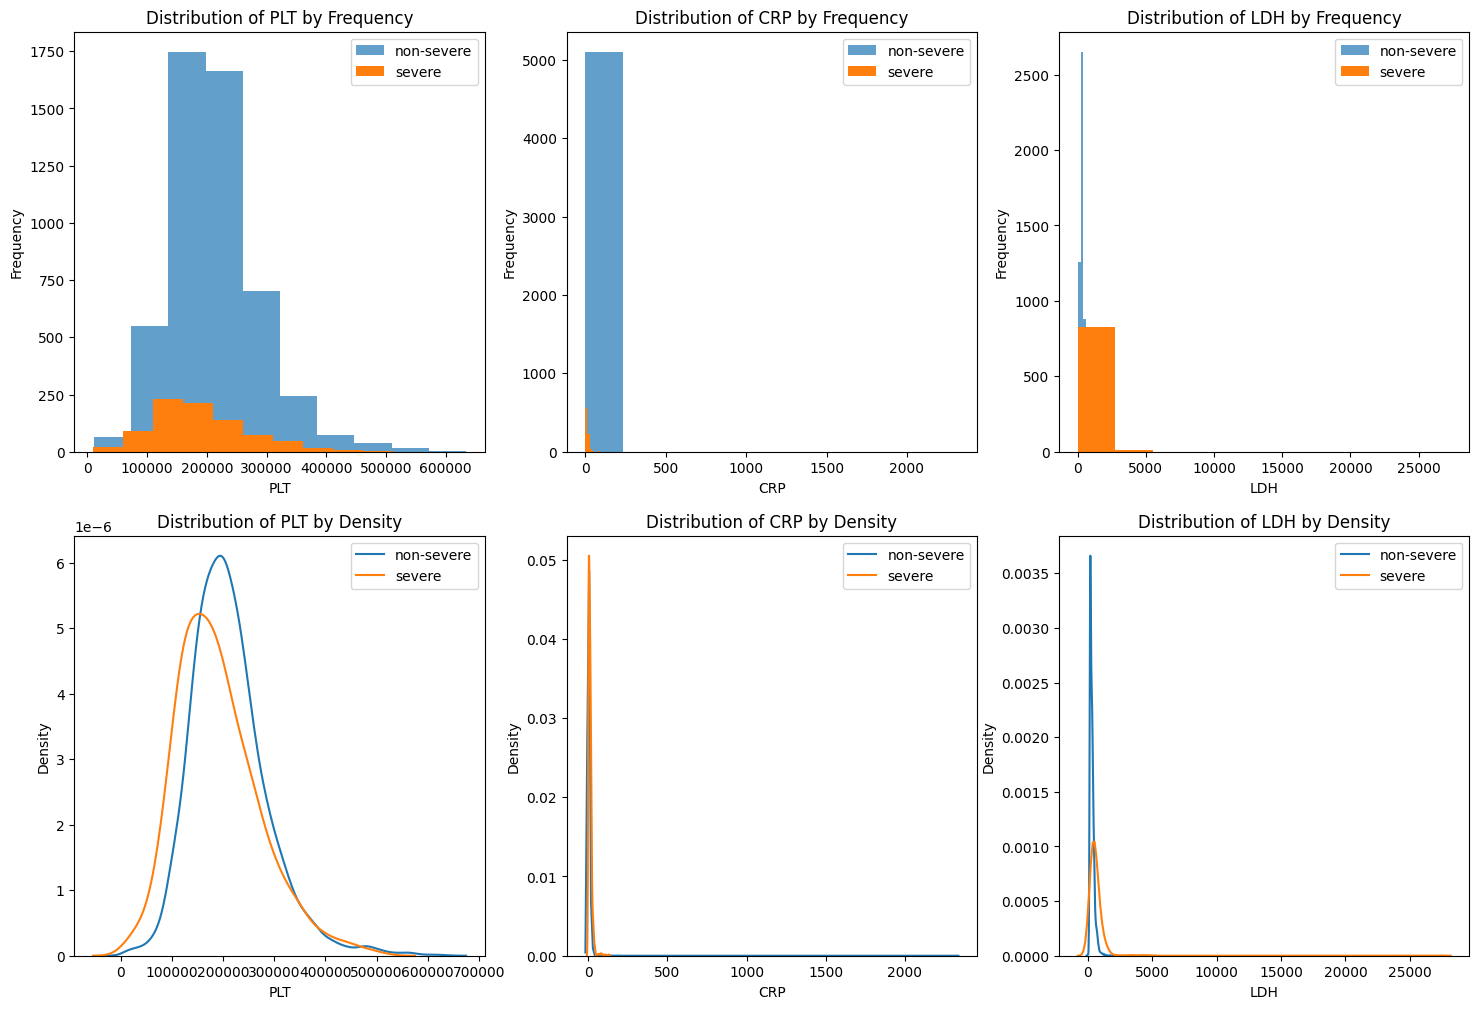

In [12]:
# seeing distributions of Testing Col features by TARGET value

# plotting histograms
testing_source = df2[['PLT', 'CRP', 'LDH']]
titles = list(enumerate(testing_source))

fig, axs = plt.subplots(2, testing_source.shape[1], figsize = (18,12))
for row in range(2):
    for i, feature in enumerate(testing_source):
        if row == 0:
            # by frequency
            axs[row,i].hist(testing_source[df2['Severe'] == 0][feature], bins = 10, label = 'non-severe', alpha = 0.7)
            axs[row,i].hist(testing_source[df2['Severe'] == 1][feature], bins = 10, label = "severe")
            axs[row,i].legend(loc='best')
            axs[row,i].set(title = 'Distribution of '+ titles[i][1] + ' by Frequency', xlabel = titles[i][1], ylabel = 'Frequency')
        else:
            # by density
            sns.kdeplot(testing_source[df2['Severe'] == 0][feature], label = 'non-severe', ax = axs[row,i])
            sns.kdeplot(testing_source[df2['Severe'] == 1][feature], label = "severe", ax = axs[row,i])
            axs[row,i].legend(loc='best')
            axs[row,i].set(title = 'Distribution of '+ titles[i][1] + ' by Density', xlabel = titles[i][1], ylabel = 'Density')
plt.show()

### Correlation Matrix per dataset

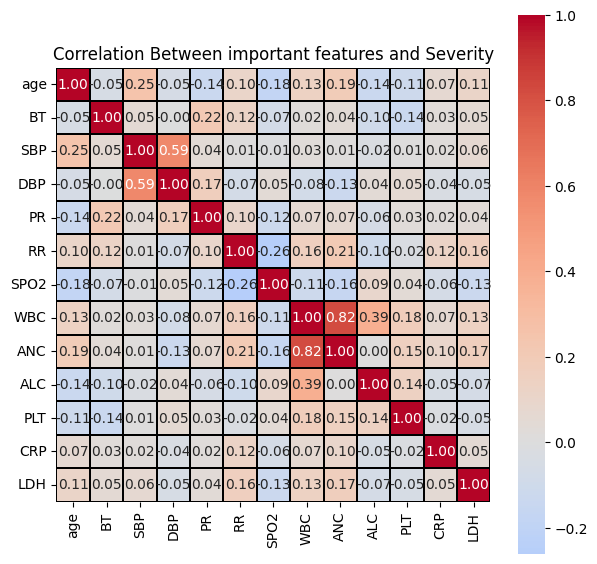

In [13]:
# correlations of important features with target (df2)
corr = df2[testingCol_DD_R].corr()
plt.figure(figsize = (7,7))
palette = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(corr, annot=True, square=True, cmap = palette, center = 0,
            linewidth = 0.1, linecolor='black', fmt='.2f')
plt.title('Correlation Between important features and Severity')
plt.show()

### Boxplots for each variables

In [14]:
basic = ['age', 'SBP', 'DBP','PR']
basic2 = ['BT', 'RR', 'SPO2']
bloodCell= ['WBC','ANC', 'ALC']
lab = ['CRP', 'LDH']

<Axes: xlabel='variable', ylabel='value'>

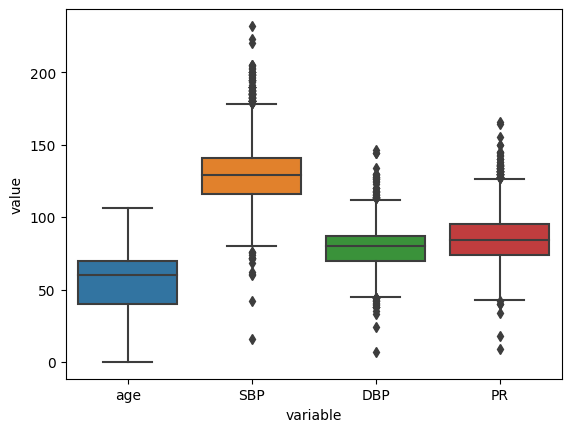

In [15]:
sns.boxplot(x='variable', y='value', data=pd.melt(df2[basic]))

<Axes: xlabel='variable', ylabel='value'>

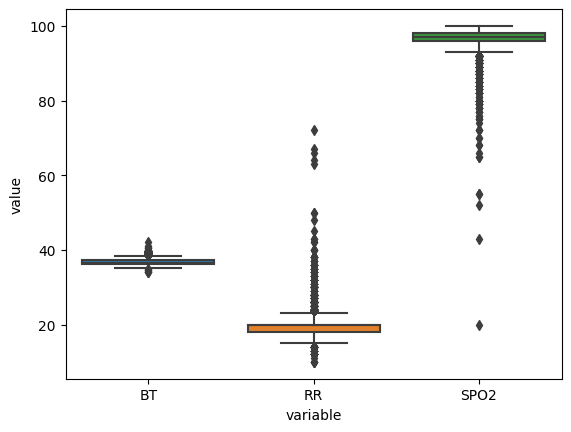

In [16]:
sns.boxplot(x='variable', y='value', data=pd.melt(df2[basic2]))

<Axes: xlabel='variable', ylabel='value'>

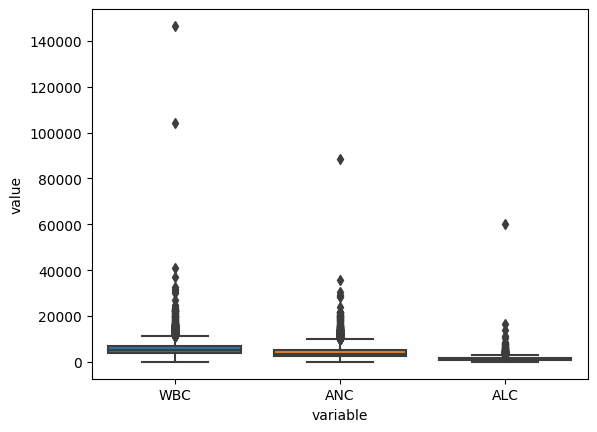

In [17]:
sns.boxplot(x='variable', y='value', data=pd.melt(df2[bloodCell]))

<Axes: xlabel='variable', ylabel='value'>

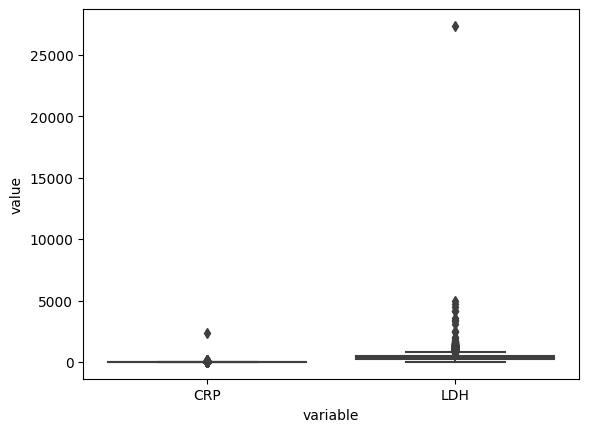

In [18]:
sns.boxplot(x='variable', y='value', data=pd.melt(df2[lab]))

In [19]:
df2.groupby('ID').count().sort_values('No', ascending=False)

,No,age,sex,dx_date,hospitalized_date,HT,DM,CVD,cancer,other,fever,cough,sputum,dyspnea,myalgia,sorethroat,mental,GI,TX_0,TX_1,TX_2,TX_3,TX_4,Smoking_0,Smoking_1,Smoking_2,Smoking_3,BT,SBP,DBP,PR,RR,SPO2,WBC,ANC,ALC,PLT,CRP,LDH,PCR,steroid,Mild,Moderate,Severe,ventilator,ECMO,ICU_date,Mortality,DevVal
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
JNU,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,1426,42,6,64,1425,1426
PNU,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,1060,34,5,34,799,1060
GIL,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,417,17,4,29,415,417
CNU,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,376,34,6,18,376,376
UEH,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,308,1,0,2,308,308
SMC,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,304,65,11,74,304,304
KNU,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,299,15,3,30,299,299
CAU,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,289,77,8,170,289,289
BRH,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,285,5,2,1,285,285


### Comparative Table (Table 1 for showing basic statistics per each patient: Severe vs. Non-severe)

In [67]:
#Age, BT, BP, PR, RR, SPO2, WBC, ANC, ALC PLT, CRP, LDH, DD
def continuous_table_func(df, item, treatment):
    T_Med = df[item].median()
    T_Q1 = np.percentile(df[item], 25, method = 'midpoint')
    T_Q3 = np.percentile(df[item], 75, method = 'midpoint')

    N_patients = df.loc[df[treatment]==0]
    N_Med = N_patients[item].median()
    N_Q1 = np.percentile(N_patients[item], 25, method = 'midpoint')
    N_Q3 = np.percentile(N_patients[item], 75, method = 'midpoint')
    
    P_patients = df.loc[df[treatment]==1]
    P_Med = P_patients[item].median()
    P_Q1 = np.percentile(P_patients[item], 25, method = 'midpoint')
    P_Q3 = np.percentile(P_patients[item], 75, method = 'midpoint')

    if item=='WBC' or item=='ANC' or item=='ALC' or item=='PLT':
        T_s = '{:,.1f} [{:,.1f}-{:,.1f}]'.format(T_Med/1000, T_Q1/1000, T_Q3/1000)
        P_s = '{:,.1f} [{:,.1f}-{:,.1f}]'.format(P_Med/1000, P_Q1/1000, P_Q3/1000)
        N_s = '{:,.1f} [{:,.1f}-{:,.1f}]'.format(N_Med/1000, N_Q1/1000, N_Q3/1000)
    else:
        T_s = '{:,.1f} [{:,.1f}-{:,.1f}]'.format(T_Med, T_Q1, T_Q3)
        P_s = '{:,.1f} [{:,.1f}-{:,.1f}]'.format(P_Med, P_Q1, P_Q3)
        N_s = '{:,.1f} [{:,.1f}-{:,.1f}]'.format(N_Med, N_Q1, N_Q3)
    
    #Computation of Standardized Mean Difference (Cohen's D)
    N_patients_mean = np.mean(N_patients[item])
    N_patients_STD = np.std(N_patients[item], ddof=1)
    N_length = len(N_patients)
    P_patients_mean = np.mean(P_patients[item])
    P_patients_STD = np.std(P_patients[item], ddof=1)
    P_length = len(P_patients)
    
    # Calculate Pooled STD using the above information
    pooled_std = np.sqrt(((N_length-1)*(N_patients_STD**2) + (P_length-1)*(P_patients_STD**2))/(N_length+P_length-2))
    SMDTestResult = (P_patients_mean - N_patients_mean) / pooled_std
    SMD_s = round(abs(SMDTestResult),3)
        
    return [T_s, P_s, N_s, SMD_s]

#['sex', 'UD_HT','UD_DM','UD_CVD','UD_cancer', 'UD_other', 'SMT_fever', 'SMT_cough', 'SMT_sputum','SMT_dyspnea', 'SMT_myalgia', 'SMT_sorethroat', 'SMT_mental', 'SMT_GI', 'steroid','TX_0','TX_1', 'TX_2', 'TX_3', 'TX_4', 'Smoking_0','Smoking_1','Smoking_2','Smoking_3']
def categorical_table_func(df, item, treatment):    
    T_Counts = len(df[df[item]==1]) 
    T_Percent = round(len(df[df[item]==1]) / (len(df))*100,1)
    T_s = '{:,} [{}%]'.format(T_Counts,T_Percent)
    
    P_patients = df.loc[df[treatment]==1]
    P_Counts = len(P_patients[P_patients[item]==1]) 
    P_Percent = round(P_Counts / (len(P_patients)) *100,1)
    P_s = '{:,} [{}%]'.format(P_Counts,P_Percent)

    N_patients = df.loc[df[treatment]==0]
    N_Counts = len(N_patients[N_patients[item]==1]) 
    N_Percent = round(N_Counts / (len(N_patients)) *100,1)
    N_s = '{:,} [{}%]'.format(N_Counts,N_Percent)
    
    # Computation of Standardized Mean Difference (Cohen's h) 
    P_proportion = P_Counts / len(P_patients)
    N_proportion = N_Counts / len(N_patients)
    
    h = 2 * np.arcsin(np.sqrt(P_proportion)) - 2 * np.arcsin(np.sqrt(N_proportion))
    SMD_s = round(abs(h), 3)
    
    return [T_s, P_s, N_s, SMD_s]

#For 'Severe' P_patients represent Severe cases, N_patients represent Non-severe cases
#For 'DevVal' P_patients (1) represent Development cases, N_patients (0) represent Validation cases
def headerCol(df, col):
    T_patients_Size = len(df)
    P_patients_Size = len(df.loc[df[col]==1])
    N_patients_Size = len(df.loc[df[col]==0])
    if col == 'Severe':
        T_head = "COVID Patients (N: {:0,})".format(T_patients_Size)
        P_head = "Severe Patients (N: {:0,})".format(P_patients_Size)
        N_head = "Non-severe Patients (N: {:0,})".format(N_patients_Size)
    elif col == 'DevVal':
        T_patients_Size= len(df)
        P_patients_Size = 4019
        N_patients_Size = 1926
        T_head = "Total Patients (N: {:0,})".format(T_patients_Size)
        P_head = "Development Set Patients (N: {:0,})".format(P_patients_Size)
        N_head = "Validation Set Patients (N: {:0,})".format(N_patients_Size)
    SMD_head = "SMD"
    return [T_head, P_head, N_head, SMD_head]

In [69]:
#Continuous variables
ContinuousCol2 = ['age', 'dx_date', 'BT', 'SBP', 'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH']
continuousList2 = [continuous_table_func(df2, item, 'Severe') for item in ContinuousCol2]

#Categorical variables
categoricalCol2 = ['sex', 'HT','DM','CVD','cancer', 'other', 'fever', 'cough', 
                   'sputum','dyspnea', 'myalgia', 'sorethroat', 'mental', 'GI',
                   'steroid','TX_0','TX_1', 'TX_2', 'TX_3', 'TX_4', 'Smoking_0','Smoking_1','Smoking_2','Smoking_3']
categoricalList2 = [categorical_table_func(df2, item, 'Severe') for item in categoricalCol2]

#Combine the Continuous and Categorical Lists
clinicalList2 = continuousList2 + categoricalList2
clinicalCol2 = ContinuousCol2 + categoricalCol2

#Reorder The Columns
ColumnReorder2 = ['age','sex','dx_date','HT','DM','CVD', 'cancer', 'other', 'fever', 
                 'cough', 'sputum','dyspnea', 'myalgia', 'sorethroat', 'mental', 'GI',
                 'BT', 'SBP', 'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH',
                 'steroid','TX_0','TX_1', 'TX_2', 'TX_3', 'TX_4', 'Smoking_0','Smoking_1','Smoking_2','Smoking_3']

#Clinical Table for Severe Vs. Non-Severe
clinicalTable_SevereNonSevere = pd.DataFrame(data=clinicalList2, columns=headerCol(df2, 'Severe'), index=clinicalCol2).reindex(ColumnReorder2)

#Save clinical tables as csv files
clinicalTable_SevereNonSevere.to_csv('../Result/ClinicalTable_Severe_NonSevere.csv')

In [22]:
clinicalTable_SevereNonSevere

,"COVID Patients (N: 5,945)",Severe Patients (N: 839),"Non-severe Patients (N: 5,106)",SMD
age,60.0 [40.0-70.0],70.0 [60.0-75.0],55.0 [40.0-70.0],0.733
sex,"2,887 [48.6%]",499 [59.5%],"2,388 [46.8%]",0.255
dx_date,0.0 [-2.0-0.0],-2.0 [-5.0-0.0],0.0 [-1.0-0.0],0.591
HT,"2,114 [35.6%]",462 [55.1%],"1,652 [32.4%]",0.462
DM,"1,249 [21.0%]",345 [41.1%],904 [17.7%],0.524
CVD,508 [8.5%],106 [12.6%],402 [7.9%],0.158
cancer,477 [8.0%],75 [8.9%],402 [7.9%],0.038
other,"2,242 [37.7%]",401 [47.8%],"1,841 [36.1%]",0.239
fever,"2,366 [39.8%]",364 [43.4%],"2,002 [39.2%]",0.085
cough,"2,623 [44.1%]",317 [37.8%],"2,306 [45.2%]",0.150


### Comparative Table (Table 1 for showing basic statistics per each patient: Development Vs. Validation)

In [23]:
continuous_DevVal = ['age', 'dx_date', 'BT', 'SBP', 'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH']
categorical_DevVal = ['sex', 'HT','DM','CVD','cancer', 'other', 'fever', 'cough', 
                   'sputum','dyspnea', 'myalgia', 'sorethroat', 'mental', 'GI',
                   'steroid','TX_0','TX_1', 'TX_2', 'TX_3', 'TX_4', 'Smoking_0','Smoking_1','Smoking_2','Smoking_3']
columnOrder_DevVal = ['age','sex','dx_date','HT','DM','CVD', 'cancer', 'other', 'fever', 
                 'cough', 'sputum','dyspnea', 'myalgia', 'sorethroat', 'mental', 'GI',
                 'BT', 'SBP', 'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH',
                 'steroid','TX_0','TX_1', 'TX_2', 'TX_3', 'TX_4', 'Smoking_0','Smoking_1','Smoking_2','Smoking_3']

continuousList_DevVal = [continuous_table_func(df2, item, 'DevVal') for item in continuous_DevVal]
categoricalList_DevVal = [categorical_table_func(df2, item, 'DevVal') for item in categorical_DevVal]
clinicalList_DevVal = continuousList_DevVal + categoricalList_DevVal
clinicalCol_DevVal = continuous_DevVal + categorical_DevVal

#For 'DevVal' (1) represent Development cases, (0) represent Validation cases
clinicalTable_DevVal = pd.DataFrame(data=clinicalList_DevVal, columns=headerCol(df2, 'DevVal'), index=clinicalCol_DevVal).reindex(columnOrder_DevVal)
clinicalTable_DevVal.to_csv('../Result/clinicalTable_DevVal.csv')

In [24]:
clinicalTable_DevVal

,"Total Patients (N: 5,945)","Development Set Patients (N: 4,019)","Validation Set Patients (N: 1,926)",SMD
age,60.0 [40.0-70.0],60.0 [45.0-70.0],50.0 [35.0-65.0],0.333
sex,"2,887 [48.6%]","2,130 [48.8%]",757 [47.9%],0.018
dx_date,0.0 [-2.0-0.0],0.0 [-2.0-0.0],-1.0 [-1.0-0.0],0.158
HT,"2,114 [35.6%]","1,622 [37.2%]",492 [31.1%],0.127
DM,"1,249 [21.0%]",978 [22.4%],271 [17.2%],0.132
CVD,508 [8.5%],389 [8.9%],119 [7.5%],0.050
cancer,477 [8.0%],369 [8.5%],108 [6.8%],0.061
other,"2,242 [37.7%]","1,813 [41.5%]",429 [27.2%],0.304
fever,"2,366 [39.8%]","1,678 [38.4%]",688 [43.5%],0.104
cough,"2,623 [44.1%]","1,852 [42.4%]",771 [48.8%],0.128


### Comparative Table (Supplementary Table for showing basic statistics per each center)

In [25]:
#Age, BT, BP, PR, RR, SPO2, WBC, ANC, ALC PLT, CRP, LDH, DD
def continuous_table_func_mc(df, item, treatment):
    T_Med = df[item].median()
    T_Q1 = np.percentile(df[item], 25, method = 'midpoint')
    T_Q3 = np.percentile(df[item], 75, method = 'midpoint')

    N_patients = df.loc[df[treatment]==0]
    N_Med = N_patients[item].median()
    N_Q1 = np.percentile(N_patients[item], 25, method = 'midpoint')
    N_Q3 = np.percentile(N_patients[item], 75, method = 'midpoint')

    P_patients = df.loc[df[treatment]==1]
    P_Med = P_patients[item].median()
    P_Q1 = np.percentile(P_patients[item], 25, method = 'midpoint')
    P_Q3 = np.percentile(P_patients[item], 75, method = 'midpoint')
        
    if item=='WBC' or item=='ANC' or item=='ALC' or item=='PLT':
        T_s = '{:,.1f} [{:,.1f}-{:,.1f}]'.format(T_Med/1000, T_Q1/1000, T_Q3/1000)
        P_s = '{:,.1f} [{:,.1f}-{:,.1f}]'.format(P_Med/1000, P_Q1/1000, P_Q3/1000)
        N_s = '{:,.1f} [{:,.1f}-{:,.1f}]'.format(N_Med/1000, N_Q1/1000, N_Q3/1000)
    else:
        T_s = '{:,.1f} [{:,.1f}-{:,.1f}]'.format(T_Med, T_Q1, T_Q3)
        P_s = '{:,.1f} [{:,.1f}-{:,.1f}]'.format(P_Med, P_Q1, P_Q3)
        N_s = '{:,.1f} [{:,.1f}-{:,.1f}]'.format(N_Med, N_Q1, N_Q3)        

    return [T_s, P_s, N_s]

def categorical_table_func_mc(df, item, treatment):    
    T_Counts = len(df[df[item]==1]) 
    T_Percent = round(len(df[df[item]==1]) / (len(df))*100,1)
    T_s = '{:,} [{}%]'.format(T_Counts,T_Percent)
    
    P_patients = df.loc[df[treatment]==1]
    P_Counts = len(P_patients[P_patients[item]==1]) 
    P_Percent = round(P_Counts / (len(P_patients)) *100,1)
    P_s = '{:,} [{}%]'.format(P_Counts,P_Percent)

    N_patients = df.loc[df[treatment]==0]
    N_Counts = len(N_patients[N_patients[item]==1]) 
    N_Percent = round(N_Counts / (len(N_patients)) *100,1)
    N_s = '{:,} [{}%]'.format(N_Counts,N_Percent)
    return [T_s, P_s, N_s]

#For 'Severe' P_patients represent Severe cases, N_patients represent Non-severe cases
#For 'DevVal' P_patients (1) represent Development cases, N_patients (0) represent Validation cases
def headerCol_mc(df, col, ID):
    T_patients_Size = len(df)
    P_patients_Size = len(df.loc[df[col]==1])
    N_patients_Size = len(df.loc[df[col]==0])
    if col == 'Severe':
        T_head = "{} COVID Patients (N: {:0,})".format(ID, T_patients_Size)
        P_head = "Severe Patients (N: {:0,})".format(P_patients_Size)
        N_head = "Non-severe Patients (N: {:0,})".format(N_patients_Size)
    elif col == 'DevVal':
        T_patients_Size= len(df)
        P_patients_Size = 4019
        N_patients_Size = 1926
        T_head = "Total Patients (N: {:0,})".format(T_patients_Size)
        P_head = "Development Set Patients (N: {:0,})".format(P_patients_Size)
        N_head = "Validation Set Patients (N: {:0,})".format(N_patients_Size)
    return [T_head, P_head, N_head]

def Clinical_Table_Builder(dataset, ID, continuous_mc, categorical_mc, ColumnReorder_mc):
    continuousList_mc = [continuous_table_func_mc(dataset, item, 'Severe') for item in continuous_mc]
    categoricalList_mc = [categorical_table_func_mc(dataset, item, 'Severe') for item in categorical_mc]
    clinicalList_mc = continuousList_mc + categoricalList_mc
    clinicalCol_mc = continuous_mc + categorical_mc
    clinicalTable_mc = pd.DataFrame(data=clinicalList_mc, columns=headerCol_mc(dataset, 'Severe', ID), index=clinicalCol_mc).reindex(ColumnReorder_mc)    
    return clinicalTable_mc

In [26]:
#Necessary List items for building CT for multicenter
continuous_mc = ['age', 'dx_date', 'BT', 'SBP', 'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH']
categorical_mc = ['sex', 'HT','DM','CVD','cancer', 'other', 'fever', 'cough', 
                   'sputum','dyspnea', 'myalgia', 'sorethroat', 'mental', 'GI',
                   'steroid','TX_0','TX_1', 'TX_2', 'TX_3', 'TX_4', 'Smoking_0','Smoking_1','Smoking_2','Smoking_3']
ColumnReorder_mc = ['age','sex','dx_date','HT','DM','CVD', 'cancer', 'other', 'fever', 
                 'cough', 'sputum','dyspnea', 'myalgia', 'sorethroat', 'mental', 'GI',
                 'BT', 'SBP', 'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH',
                 'steroid','TX_0','TX_1', 'TX_2', 'TX_3', 'TX_4', 'Smoking_0','Smoking_1','Smoking_2','Smoking_3']

In [27]:
#Development datasets
D1 = df2[df2['ID']=='BRH']
D2 = df2[df2['ID']=='UEH']
D3 = df2[df2['ID']=='KWU']
D4 = df2[df2['ID']=='KMU']
D5 = df2[df2['ID']=='BSH']
D6 = df2[df2['ID']=='AUH']
D7 = df2[df2['ID']=='SNU']
D8 = df2[df2['ID']=='CAU']
D9 = df2[df2['ID']=='GIL']
D10 = df2[df2['ID']=='DCM']
D11 = df2[df2['ID']=='CBU']
D12 = df2[df2['ID']=='JBU']
D13 = df2[df2['ID']=='KNU']
D14 = df2[df2['ID']=='CNU']
D15 = df2[df2['ID']=='PNU']

#Validation Datasets
V1 = df2[df2['ID']=='SCH']
V2 = df2[df2['ID']=='SCN']
V3 = df2[df2['ID']=='SMC']
V4 = df2[df2['ID']=='JNU']

In [28]:
#Clinical Tables per Centers
CT_D1_BRH = Clinical_Table_Builder(D1, 'BRH', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_D2_UEH = Clinical_Table_Builder(D2, 'UEH', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_D3_KWU = Clinical_Table_Builder(D3, 'KWU', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_D4_KMU = Clinical_Table_Builder(D4, 'KMU', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_D5_BSH = Clinical_Table_Builder(D5, 'BSH', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_D6_AUH = Clinical_Table_Builder(D6, 'AUH', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_D7_SNU = Clinical_Table_Builder(D7, 'SNU', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_D8_CAU = Clinical_Table_Builder(D8, 'CAU', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_D9_GIL = Clinical_Table_Builder(D9, 'GIL', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_D10_DCM = Clinical_Table_Builder(D10, 'DCM', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_D11_CBU = Clinical_Table_Builder(D11, 'CBU', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_D12_JBU = Clinical_Table_Builder(D12, 'JBU', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_D13_KNU = Clinical_Table_Builder(D13, 'KNU', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_D14_CNU = Clinical_Table_Builder(D14, 'CNU', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_D15_PNU = Clinical_Table_Builder(D15, 'PNU', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_V1_SCH = Clinical_Table_Builder(V1, 'SCH', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_V2_SCN = Clinical_Table_Builder(V2, 'SCN', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_V3_SMC = Clinical_Table_Builder(V3, 'SMC', continuous_mc, categorical_mc, ColumnReorder_mc)
CT_V4_JNU = Clinical_Table_Builder(V4, 'JNU', continuous_mc, categorical_mc, ColumnReorder_mc)

#Multi-Center Clinical Tables
CT_ALL_MC = pd.concat([CT_D1_BRH, CT_D2_UEH, CT_D3_KWU, CT_D4_KMU, CT_D5_BSH, CT_D6_AUH, CT_D7_SNU,
                      CT_D8_CAU, CT_D9_GIL, CT_D10_DCM, CT_D11_CBU, CT_D12_JBU, CT_D13_KNU,
                      CT_D14_CNU, CT_D15_PNU, CT_V1_SCH, CT_V2_SCN, CT_V3_SMC, CT_V4_JNU], axis=1)
CT_ALL_MC.to_csv('../Result/clinicalTable_MultiCenter.csv')

In [29]:
CT_ALL_MC

,BRH COVID Patients (N: 285),Severe Patients (N: 6),Non-severe Patients (N: 279),UEH COVID Patients (N: 308),Severe Patients (N: 3),Non-severe Patients (N: 305),KWU COVID Patients (N: 21),Severe Patients (N: 17),Non-severe Patients (N: 4),KMU COVID Patients (N: 197),Severe Patients (N: 17),Non-severe Patients (N: 180),BSH COVID Patients (N: 29),Severe Patients (N: 16),Non-severe Patients (N: 13),AUH COVID Patients (N: 149),Severe Patients (N: 43),Non-severe Patients (N: 106),SNU COVID Patients (N: 197),Severe Patients (N: 61),Non-severe Patients (N: 136),CAU COVID Patients (N: 289),Severe Patients (N: 171),Non-severe Patients (N: 118),GIL COVID Patients (N: 417),Severe Patients (N: 41),Non-severe Patients (N: 376),DCM COVID Patients (N: 60),Severe Patients (N: 9),Non-severe Patients (N: 51),CBU COVID Patients (N: 128),Severe Patients (N: 22),Non-severe Patients (N: 106),JBU COVID Patients (N: 204),Severe Patients (N: 58),Non-severe Patients (N: 146),KNU COVID Patients (N: 299),Severe Patients (N: 31),Non-severe Patients (N: 268),CNU COVID Patients (N: 376),Severe Patients (N: 39),Non-severe Patients (N: 337),"PNU COVID Patients (N: 1,060)",Severe Patients (N: 71),Non-severe Patients (N: 989),SCH COVID Patients (N: 154),Severe Patients (N: 47),Non-severe Patients (N: 107),SCN COVID Patients (N: 42),Severe Patients (N: 14),Non-severe Patients (N: 28),SMC COVID Patients (N: 304),Severe Patients (N: 89),Non-severe Patients (N: 215),"JNU COVID Patients (N: 1,426)",Severe Patients (N: 84),"Non-severe Patients (N: 1,342)"
age,45.0 [30.0-60.0],70.0 [65.0-70.0],45.0 [30.0-60.0],55.0 [37.5-65.0],60.0 [55.0-62.5],55.0 [35.0-65.0],75.0 [70.0-80.0],75.0 [70.0-80.0],77.5 [70.0-85.0],65.0 [55.0-75.0],75.0 [65.0-85.0],65.0 [55.0-70.0],65.0 [55.0-75.0],67.5 [60.0-77.5],60.0 [55.0-75.0],65.0 [60.0-75.0],70.0 [62.5-75.0],65.0 [60.0-70.0],65.0 [50.0-70.0],70.0 [60.0-75.0],60.0 [45.0-70.0],65.0 [55.0-70.0],65.0 [55.0-75.0],60.0 [42.5-70.0],55.0 [40.0-75.0],65.0 [55.0-80.0],55.0 [40.0-70.0],65.0 [50.0-75.0],70.0 [60.0-75.0],60.0 [50.0-75.0],60.0 [50.0-75.0],72.5 [60.0-80.0],60.0 [45.0-75.0],55.0 [40.0-65.0],60.0 [50.0-72.5],55.0 [37.5-65.0],65.0 [50.0-70.0],70.0 [65.0-75.0],60.0 [50.0-70.0],55.0 [45.0-65.0],70.0 [60.0-75.0],55.0 [45.0-65.0],60.0 [40.0-70.0],70.0 [65.0-80.0],60.0 [40.0-70.0],65.0 [55.0-75.0],70.0 [60.0-77.5],65.0 [52.5-75.0],70.0 [60.0-80.0],67.5 [60.0-82.5],70.0 [57.5-77.5],65.0 [50.0-70.0],70.0 [65.0-75.0],60.0 [50.0-70.0],50.0 [35.0-65.0],70.0 [60.0-80.0],50.0 [35.0-65.0]
sex,94 [33.0%],2 [33.3%],92 [33.0%],155 [50.3%],2 [66.7%],153 [50.2%],15 [71.4%],13 [76.5%],2 [50.0%],66 [33.5%],12 [70.6%],54 [30.0%],14 [48.3%],8 [50.0%],6 [46.2%],85 [57.0%],24 [55.8%],61 [57.5%],114 [57.9%],40 [65.6%],74 [54.4%],169 [58.5%],104 [60.8%],65 [55.1%],192 [46.0%],26 [63.4%],166 [44.1%],26 [43.3%],5 [55.6%],21 [41.2%],70 [54.7%],13 [59.1%],57 [53.8%],116 [56.9%],40 [69.0%],76 [52.1%],149 [49.8%],21 [67.7%],128 [47.8%],176 [46.8%],18 [46.2%],158 [46.9%],486 [45.8%],39 [54.9%],447 [45.2%],102 [66.2%],32 [68.1%],70 [65.4%],25 [59.5%],8 [57.1%],17 [60.7%],178 [58.6%],51 [57.3%],127 [59.1%],655 [45.9%],41 [48.8%],614 [45.8%]
dx_date,0.0 [-1.0-0.0],0.0 [0.0-0.0],0.0 [-1.0-0.0],0.0 [-1.0-0.0],0.0 [-2.0-0.0],0.0 [-1.0-0.0],-4.0 [-7.0-0.0],-4.0 [-8.0--1.0],-1.5 [-5.0-0.0],-5.0 [-7.0--3.0],-4.0 [-4.0--3.0],-5.0 [-7.0--3.0],-1.0 [-2.0-0.0],-0.5 [-5.0-0.0],-1.0 [-1.0-0.0],-1.0 [-3.0-0.0],-2.0 [-7.0--0.5],-1.0 [-2.0-0.0],-1.0 [-5.0-0.0],-4.0 [-6.0--1.0],-1.0 [-3.0-0.0],-1.0 [-5.0-0.0],-2.0 [-6.0-0.0],-1.0 [-2.0-0.0],-1.0 [-3.0--1.0],-1.0 [-5.0-0.0],-1.0 [-3.0--1.0],-3.0 [-5.0--1.0],-1.0 [-1.0-0.0],-3.0 [-5.0--1.0],-3.0 [-7.0--1.0],-3.5 [-6.0--1.0],-3.0 [-7.0--1.0],-1.0 [-5.0--1.0],-2.0 [-6.0--1.0],-1.0 [-4.0--1.0],-1.0 [-2.0-0.0],-3.0 [-5.5-0.0],0.0 [-2.0-0.0],0.0 [0.0-0.0],0.0 [-1.0-0.0],0.0 [0.0-0.0],0.0 [0.0-0.0],0.0 [0.0-0.0],0.0 [0.0-0.0],0.0 [-5.0-0.0],-1.0 [-5.5-0.0],0.0 [-4.0-0.0],-2.0 [-5.5-0.0],-2.0 [-4.5--0.5],-1.5 [-5.5-0.0],-1.0 [-5.0-0.0],-2.0 [-

### Violin Plots per each center to show distributions of important variables

In [30]:
Important_Variables = ['ANC', 'ALC', 'LDH', 'RR', 'WBC', 'DBP', 'CRP','SPO2', 'PLT', 'dyspnea', 'age', 'DM']

#Development datasets
D1 = df2[df2['ID']=='BRH']
D2 = df2[df2['ID']=='UEH']
D3 = df2[df2['ID']=='KWU']
D4 = df2[df2['ID']=='KMU']
D5 = df2[df2['ID']=='BSH']
D6 = df2[df2['ID']=='AUH']
D7 = df2[df2['ID']=='SNU']
D8 = df2[df2['ID']=='CAU']
D9 = df2[df2['ID']=='GIL']
D10 = df2[df2['ID']=='DCM']
D11 = df2[df2['ID']=='CBU']
D12 = df2[df2['ID']=='JBU']
D13 = df2[df2['ID']=='KNU']
D14 = df2[df2['ID']=='CNU']
D15 = df2[df2['ID']=='PNU']

#Validation Datasets
V1 = df2[df2['ID']=='SCH']
V2 = df2[df2['ID']=='SCN']
V3 = df2[df2['ID']=='SMC']
V4 = df2[df2['ID']=='JNU']

In [31]:
def min_max_hospitalized_date(dataframes, date_column='hospitalized_date'):
    min_date = None
    max_date = None

    for df in dataframes:
        current_min_date = df[date_column].min()
        current_max_date = df[date_column].max()

        if min_date is None or current_min_date < min_date:
            min_date = current_min_date

        if max_date is None or current_max_date > max_date:
            max_date = current_max_date

    return min_date, max_date

In [32]:
def combined_length(dataframes):
    total_length = 0

    for df in dataframes:
        total_length += len(df)

    return total_length

In [33]:
#Development Cohort
development_hospitals = [D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15]
d_length=combined_length(development_hospitals)
print(f"Combined length of development hospitals: {d_length}")
#Validation Cohort
validation_hospitals = [V1,V2,V3,V4]
v_length=combined_length(validation_hospitals)
print(f"Combined length of validation hospitals: {v_length}")


Combined length of development hospitals: 4019
Combined length of validation hospitals: 1926


In [34]:
#metropolitan_general_hospitals
min_dev_date, max_dev_date = min_max_hospitalized_date(development_hospitals)
print(f"Earliest date for development cohort : {min_dev_date}")
print(f"Latest date for development cohort: {max_dev_date}")

#metropolitan_general_hospitals
min_dev_date, max_dev_date = min_max_hospitalized_date(validation_hospitals)
print(f"Earliest date for validation cohort : {min_dev_date}")
print(f"Latest date for validation cohort: {max_dev_date}")

Earliest date for development cohort : 2020-01-26
Latest date for development cohort: 2022-08-29
Earliest date for validation cohort : 2020-01-05
Latest date for validation cohort: 2022-08-23


In [35]:
# Combine your dataframes into a list
metropolitan_general_hospitals = [D1, D2, V1]
non_metropolitan_metropolitan_general_hospitals_hospitals = [D3, D4, V2] 
metropolitan_tertiary_care_hospitals = [D5, D6, D7, D8, D9, V3]
non_metropolitan_tertiary_care_hospitals = [D10, D11, D12, D13, D14, D15, V4]

#metropolitan_general_hospitals
min_dev_date, max_dev_date = min_max_hospitalized_date(metropolitan_general_hospitals)
print(f"Earliest date for metropolitan_general_hospitals : {min_dev_date}")
print(f"Latest date for metropolitan_general_hospitals: {max_dev_date}")

#non_metropolitan_metropolitan_general_hospitals_hospitals
min_dev_date, max_dev_date = min_max_hospitalized_date(non_metropolitan_metropolitan_general_hospitals_hospitals)
print(f"Earliest date for non_metropolitan_metropolitan_general_hospitals_hospitals: {min_dev_date}")
print(f"Latest date for non_metropolitan_metropolitan_general_hospitals_hospitals: {max_dev_date}")

#metropolitan_tertiary_care_hospitals
min_dev_date, max_dev_date = min_max_hospitalized_date(metropolitan_tertiary_care_hospitals)
print(f"Earliest date for metropolitan_tertiary_care_hospitalss: {min_dev_date}")
print(f"Latest date for metropolitan_tertiary_care_hospitals: {max_dev_date}")

#non_metropolitan_tertiary_care_hospitals
min_dev_date, max_dev_date = min_max_hospitalized_date(non_metropolitan_tertiary_care_hospitals)
print(f"Earliest date for non_metropolitan_tertiary_care_hospitals: {min_dev_date}")
print(f"Latest date for non_metropolitan_tertiary_care_hospitals: {max_dev_date}")

Earliest date for metropolitan_general_hospitals : 2020-02-25
Latest date for metropolitan_general_hospitals: 2022-04-17
Earliest date for non_metropolitan_metropolitan_general_hospitals_hospitals: 2020-03-01
Latest date for non_metropolitan_metropolitan_general_hospitals_hospitals: 2022-08-23
Earliest date for metropolitan_tertiary_care_hospitalss: 2020-01-26
Latest date for metropolitan_tertiary_care_hospitals: 2022-08-29
Earliest date for non_metropolitan_tertiary_care_hospitals: 2020-01-05
Latest date for non_metropolitan_tertiary_care_hospitals: 2022-04-16


In [36]:
# Calculate the combined lengths for each list of dataframes
length_metro_general = combined_length(metropolitan_general_hospitals)
length_non_metro_general = combined_length(non_metropolitan_metropolitan_general_hospitals_hospitals)
length_metro_tertiary = combined_length(metropolitan_tertiary_care_hospitals)
length_non_metro_tertiary = combined_length(non_metropolitan_tertiary_care_hospitals)

# Print the combined lengths
print(f"Combined length of metropolitan general hospitals: {length_metro_general}")
print(f"Combined length of non-metropolitan general hospitals: {length_non_metro_general}")
print(f"Combined length of metropolitan tertiary care hospitals: {length_metro_tertiary}")
print(f"Combined length of non-metropolitan tertiary care hospitals: {length_non_metro_tertiary}")

Combined length of metropolitan general hospitals: 747
Combined length of non-metropolitan general hospitals: 260
Combined length of metropolitan tertiary care hospitals: 1385
Combined length of non-metropolitan tertiary care hospitals: 3553


In [37]:
M_G_D = [D1, D2]
M_G_V = [V1]
NM_G_D = [D3, D4]
NM_G_V = [V2]
M_TC_D = [D5, D6, D7, D8, D9]
M_TC_V = [V3]
NM_TC_D = [D10, D11, D12, D13, D14, D15]
NM_TC_V = [V4]

In [38]:
print(f"Combined length of metropolitan general hospitals D: {combined_length(M_G_D)}")
print(f"Combined length of metropolitan general hospitals V: {combined_length(M_G_V)}")
print(f"Combined length of non-metropolitan general hospitals D: {combined_length(NM_G_D)}")
print(f"Combined length of non-metropolitan general hospitals V: {combined_length(NM_G_V)}")
print(f"Combined length of metropolitan tertiary care hospitals D: {combined_length(M_TC_D)}")
print(f"Combined length of metropolitan tertiary care hospitals V: {combined_length(M_TC_V)}")
print(f"Combined length of non-metropolitan tertiary care hospitals D: {combined_length(NM_TC_D)}")
print(f"Combined length of non-metropolitan tertiary care hospitals V: {combined_length(NM_TC_V)}")

Combined length of metropolitan general hospitals D: 593
Combined length of metropolitan general hospitals V: 154
Combined length of non-metropolitan general hospitals D: 218
Combined length of non-metropolitan general hospitals V: 42
Combined length of metropolitan tertiary care hospitals D: 1081
Combined length of metropolitan tertiary care hospitals V: 304
Combined length of non-metropolitan tertiary care hospitals D: 2127
Combined length of non-metropolitan tertiary care hospitals V: 1426


In [39]:
def count_severe_cases(dataframes, severe_column='Severe'):
    severe_count = 0
    non_severe_count = 0

    for df in dataframes:
        severe_count += (df[severe_column] == 1).sum()
        non_severe_count += (df[severe_column] == 0).sum()

    return severe_count, non_severe_count

# Define your lists of dataframes
M_G_D = [D1, D2]
M_G_V = [V1]
NM_G_D = [D3, D4]
NM_G_V = [V2]
M_TC_D = [D5, D6, D7, D8, D9]
M_TC_V = [V3]
NM_TC_D = [D10, D11, D12, D13, D14, D15]
NM_TC_V = [V4]

# Calculate the severe and non-severe cases for each list of dataframes
severe_M_G_D, non_severe_M_G_D = count_severe_cases(M_G_D)
severe_M_G_V, non_severe_M_G_V = count_severe_cases(M_G_V)
severe_NM_G_D, non_severe_NM_G_D = count_severe_cases(NM_G_D)
severe_NM_G_V, non_severe_NM_G_V = count_severe_cases(NM_G_V)
severe_M_TC_D, non_severe_M_TC_D = count_severe_cases(M_TC_D)
severe_M_TC_V, non_severe_M_TC_V = count_severe_cases(M_TC_V)
severe_NM_TC_D, non_severe_NM_TC_D = count_severe_cases(NM_TC_D)
severe_NM_TC_V, non_severe_NM_TC_V = count_severe_cases(NM_TC_V)

# Print the counts of severe and non-severe cases
print(f"Severe and non-severe counts for M_G_D: {severe_M_G_D}, {non_severe_M_G_D}")
print(f"Severe and non-severe counts for M_G_V: {severe_M_G_V}, {non_severe_M_G_V}")
print(f"Severe and non-severe counts for NM_G_D: {severe_NM_G_D}, {non_severe_NM_G_D}")
print(f"Severe and non-severe counts for NM_G_V: {severe_NM_G_V}, {non_severe_NM_G_V}")
print(f"Severe and non-severe counts for M_TC_D: {severe_M_TC_D}, {non_severe_M_TC_D}")
print(f"Severe and non-severe counts for M_TC_V: {severe_M_TC_V}, {non_severe_M_TC_V}")
print(f"Severe and non-severe counts for NM_TC_D: {severe_NM_TC_D}, {non_severe_NM_TC_D}")
print(f"Severe and non-severe counts for NM_TC_V: {severe_NM_TC_V}, {non_severe_NM_TC_V}")

Severe and non-severe counts for M_G_D: 9, 584
Severe and non-severe counts for M_G_V: 47, 107
Severe and non-severe counts for NM_G_D: 34, 184
Severe and non-severe counts for NM_G_V: 14, 28
Severe and non-severe counts for M_TC_D: 332, 749
Severe and non-severe counts for M_TC_V: 89, 215
Severe and non-severe counts for NM_TC_D: 230, 1897
Severe and non-severe counts for NM_TC_V: 84, 1342


In [52]:
metropolitan_general_hospitals = [D1, D2, V1]
non_metropolitan_metropolitan_general_hospitals_hospitals = [D3, D4, V2] 
metropolitan_tertiary_care_hospitals = [D5, D6, D7, D8, D9, V3]
non_metropolitan_tertiary_care_hospitals = [D10, D11, D12, D13, D14, D15, V4]

severe_M_G, non_severe_M_G = count_severe_cases(metropolitan_general_hospitals)
severe_M_TC, non_severe_M_TC = count_severe_cases(metropolitan_tertiary_care_hospitals)
severe_NM_G, non_severe_NM_G = count_severe_cases(non_metropolitan_metropolitan_general_hospitals_hospitals)
severe_NM_TC, non_severe_NM_TC = count_severe_cases(non_metropolitan_tertiary_care_hospitals)


print(f"Severe and non-severe counts for M_G: {severe_M_G}, {non_severe_M_G}")
print(f"Severe and non-severe counts for M_TC: {severe_M_TC}, {non_severe_M_TC}")
print(f"Severe and non-severe counts for NM_G: {severe_NM_G}, {non_severe_NM_G}")
print(f"Severe and non-severe counts for NM_TC: {severe_NM_TC}, {non_severe_NM_TC}")

Severe and non-severe counts for M_G: 56, 691
Severe and non-severe counts for M_TC: 421, 964
Severe and non-severe counts for NM_G: 48, 212
Severe and non-severe counts for NM_TC: 314, 3239


In [ ]:
P_counts = 56, N_Counts = 691, P_total = 

In [71]:
def calculate_SMD(pos_treatment, total_treatment, pos_control, total_control):
    prop_treatment = pos_treatment / total_treatment
    prop_control = pos_control / total_control

    h = 2 * (np.arcsin(np.sqrt(prop_treatment)) - np.arcsin(np.sqrt(prop_control)))
    SMD = abs(h)

    return SMD

SMD_M_G = calculate_SMD(severe_M_G, 839, non_severe_M_G, 5106)
SMD_M_TC = calculate_SMD(severe_M_TC, 839, non_severe_M_TC, 5106)
SMD_NM_G = calculate_SMD(severe_NM_G, 839, non_severe_NM_G, 5106)
SMD_NM_TC = calculate_SMD(severe_NM_TC, 839, non_severe_NM_TC, 5106)

print(f"SMD for M_G: {SMD_M_G}")
print(f"SMD for M_TC: {SMD_M_TC}")
print(f"SMD for NM_G: {SMD_NM_G}")
print(f"SMD for NM_TC: {SMD_NM_TC}")

SMD for M_G: 0.23080916460116652
SMD for M_TC: 0.675387388941124
SMD for NM_G: 0.07265709242722174
SMD for NM_TC: 0.5262660533431347


In [40]:
def remove_outliers(df, variables, threshold=2.5):
    for variable in variables:
        mean = df[variable].mean()
        std = df[variable].std()

        lower_bound = mean - threshold * std
        upper_bound = mean + threshold * std

        df = df[(df[variable] >= lower_bound) & (df[variable] <= upper_bound)]
    
    return df

def draw_violin_plots(dataframes, labels, important_variables):
    # Assign color to each center
    center_color_dict = {'D1': 'red', 'D2': 'red', 'V1': 'red',
                         'D3': 'orange', 'D4': 'orange', 'V2': 'orange',
                         'D5': 'blue', 'D6': 'blue', 'D7': 'blue', 'D8': 'blue', 'D9': 'blue', 'V3': 'blue',
                         'D10': 'green', 'D11': 'green', 'D12': 'green', 'D13': 'green', 'D14': 'green', 'D15': 'green', 'V4': 'green'}

    # Combine all the data into a single DataFrame with a new 'Center' column
    combined_df = pd.concat([df.assign(Center=label) for df, label in zip(dataframes, labels)])
    
    # Create a dictionary mapping variable names to their units
    variable_units = {
        'ANC': '/μL',
        'ALC': '/μL',
        'LDH': 'U/L',
        'RR': 'BPM',
        'WBC': '/μL',
        'DBP': 'mmHg',
        'CRP': 'mg/dL',
        'SPO2': '%',
        'PLT': '/μL',
        'AGE': 'years'}
    # Create violin plots for each important variable
    for variable in important_variables:
        plt.figure(figsize=(12,12))

        sns.violinplot(x='Center', y=variable, data=combined_df, palette=center_color_dict)
        variable_title = variable.capitalize() if variable in ['age'] else variable
        plt.title(f'{variable_title} Distribution by Center', size=20)
        plt.xlabel('Center', size=20)
        plt.ylabel(f"{variable_title} ({variable_units.get(variable, '')})", size=20)
        plt.xticks(rotation=45)
        
        # Save the figure as a PNG image
        plt.savefig(f'../Result/{variable_title}_distribution_by_center.png', dpi=300)
        
        plt.show()

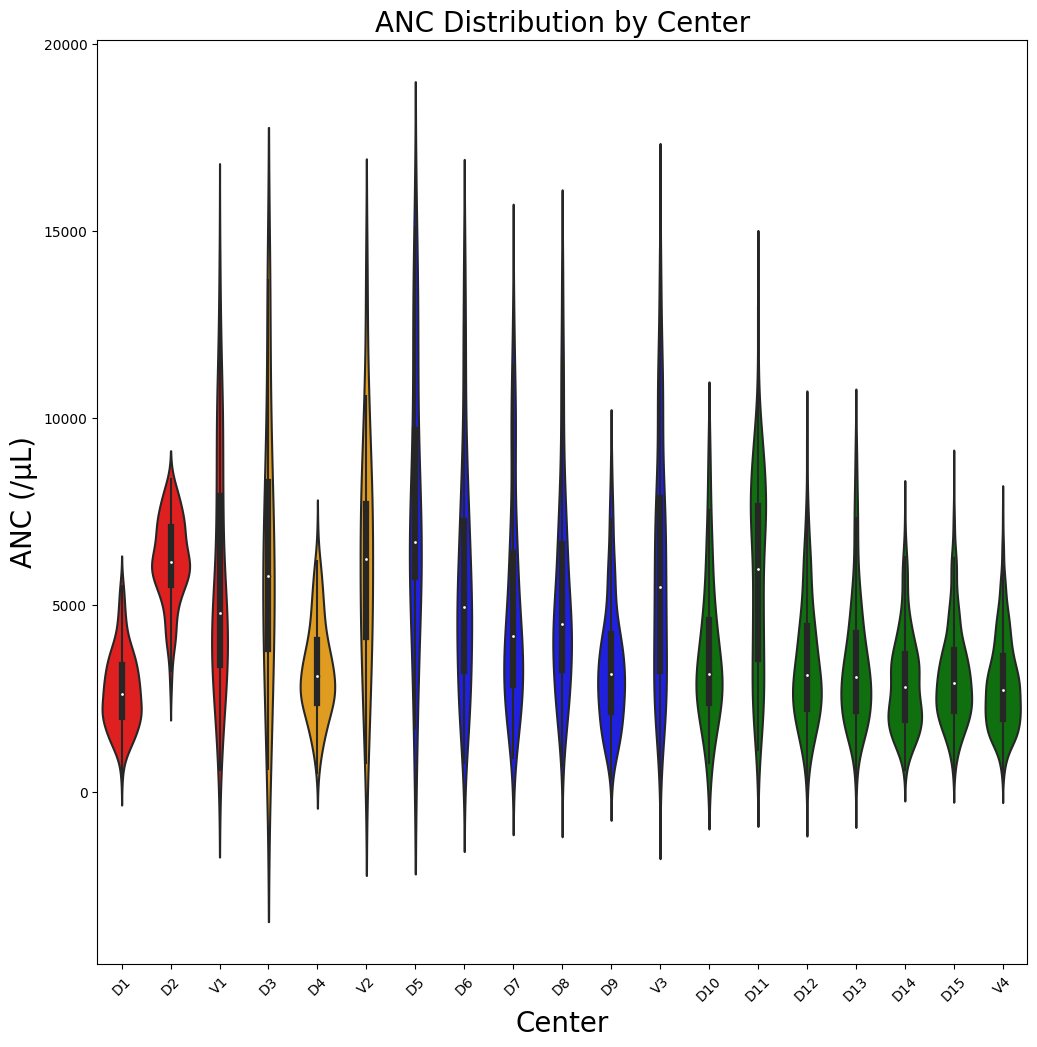

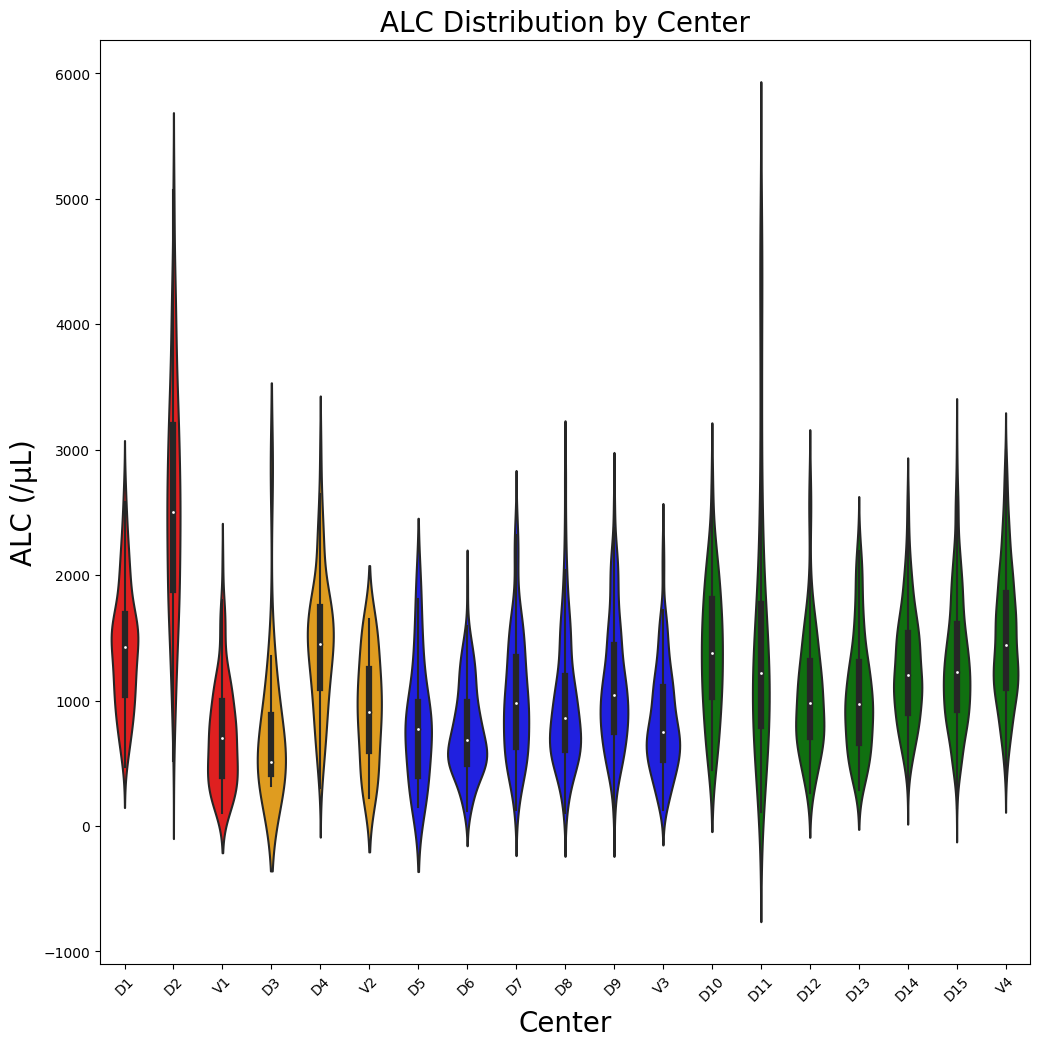

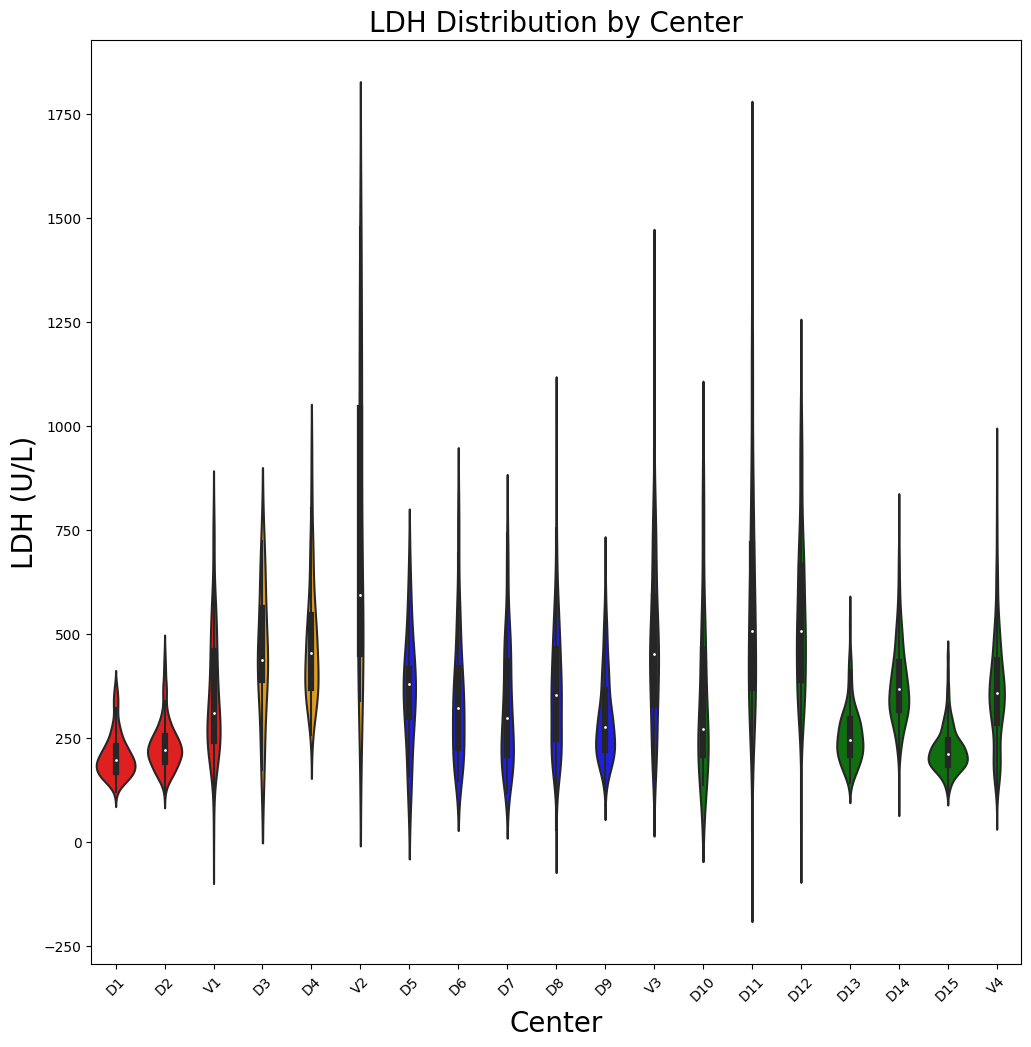

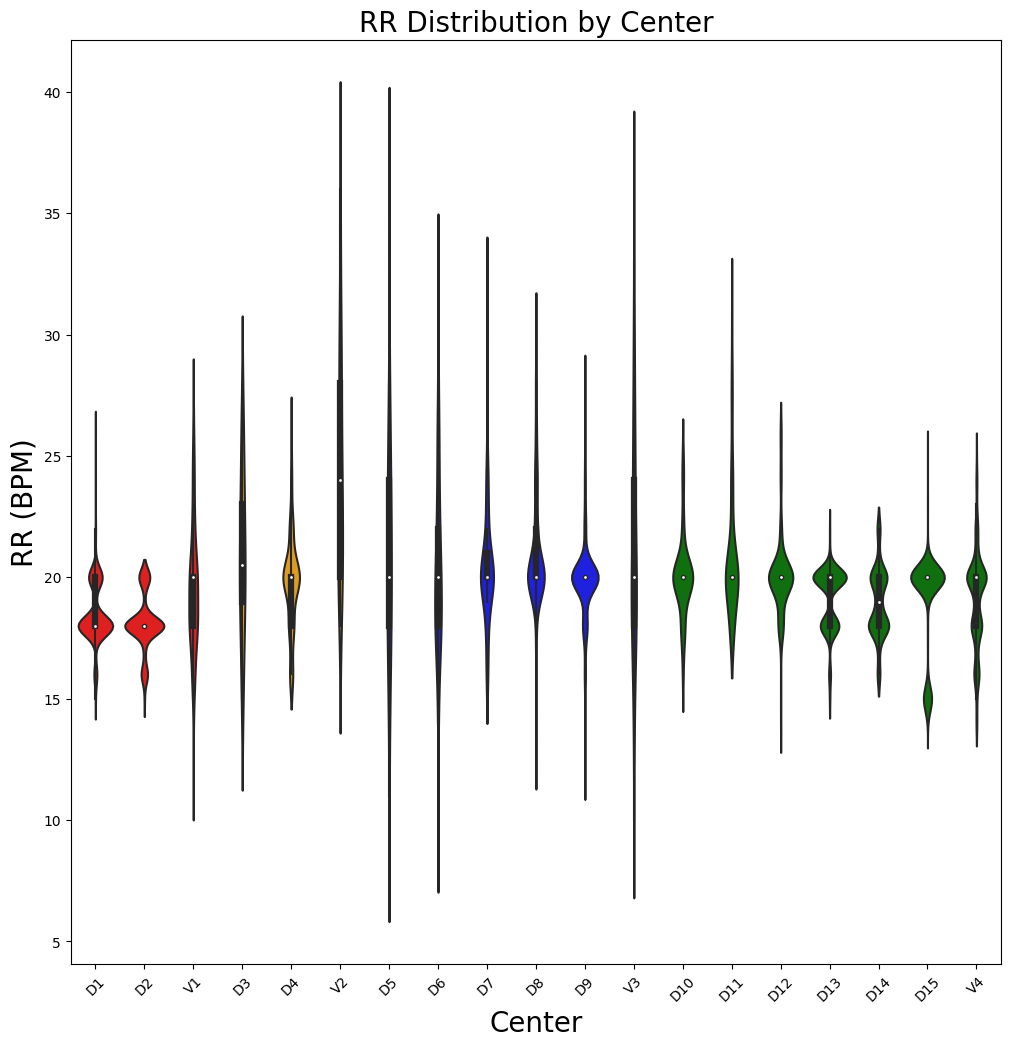

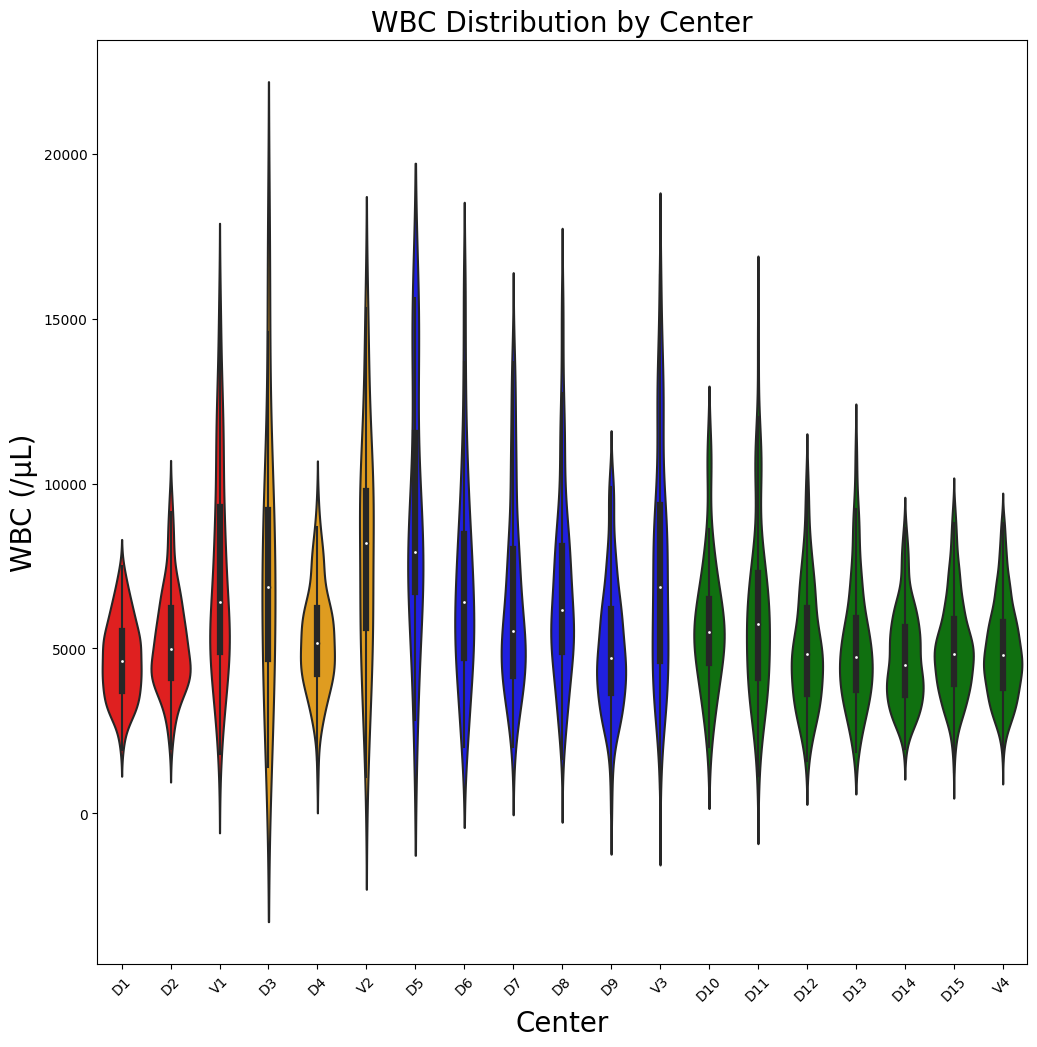

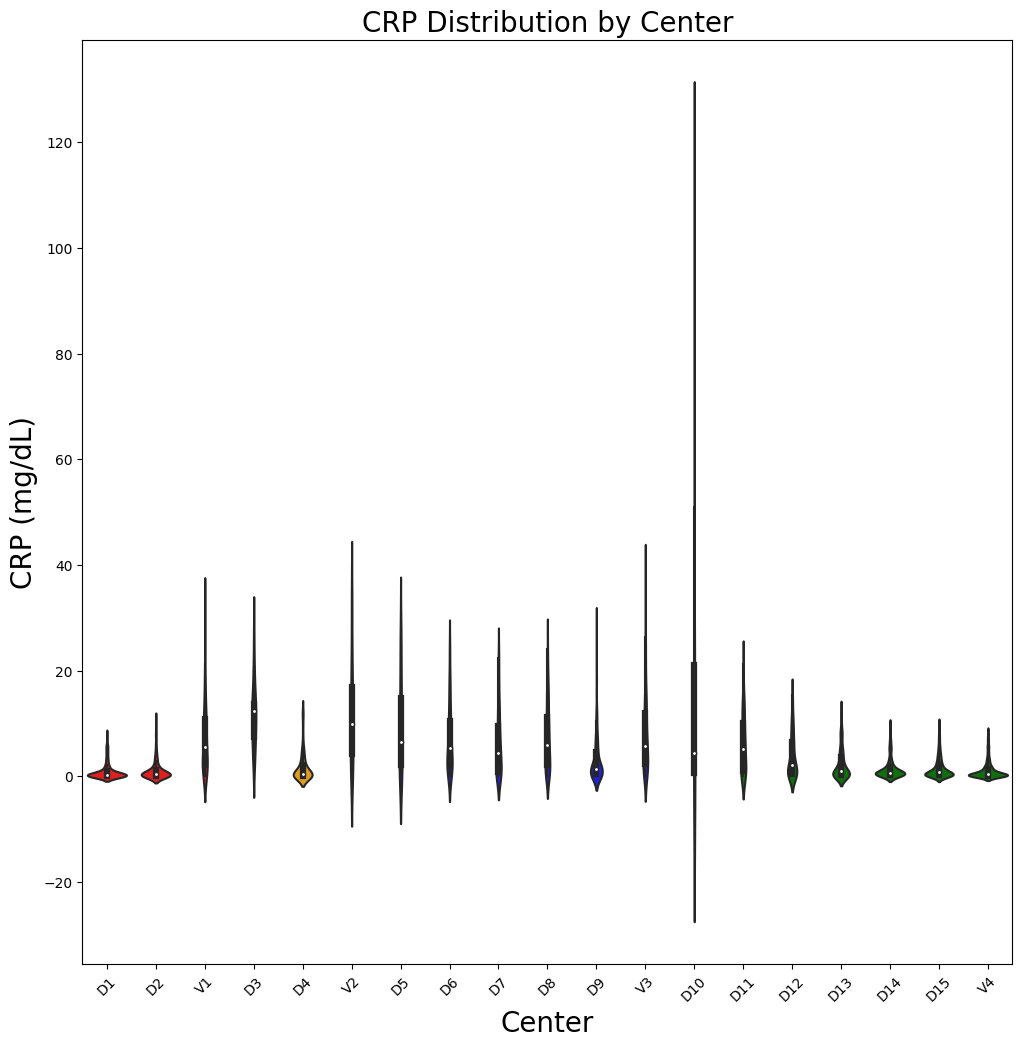

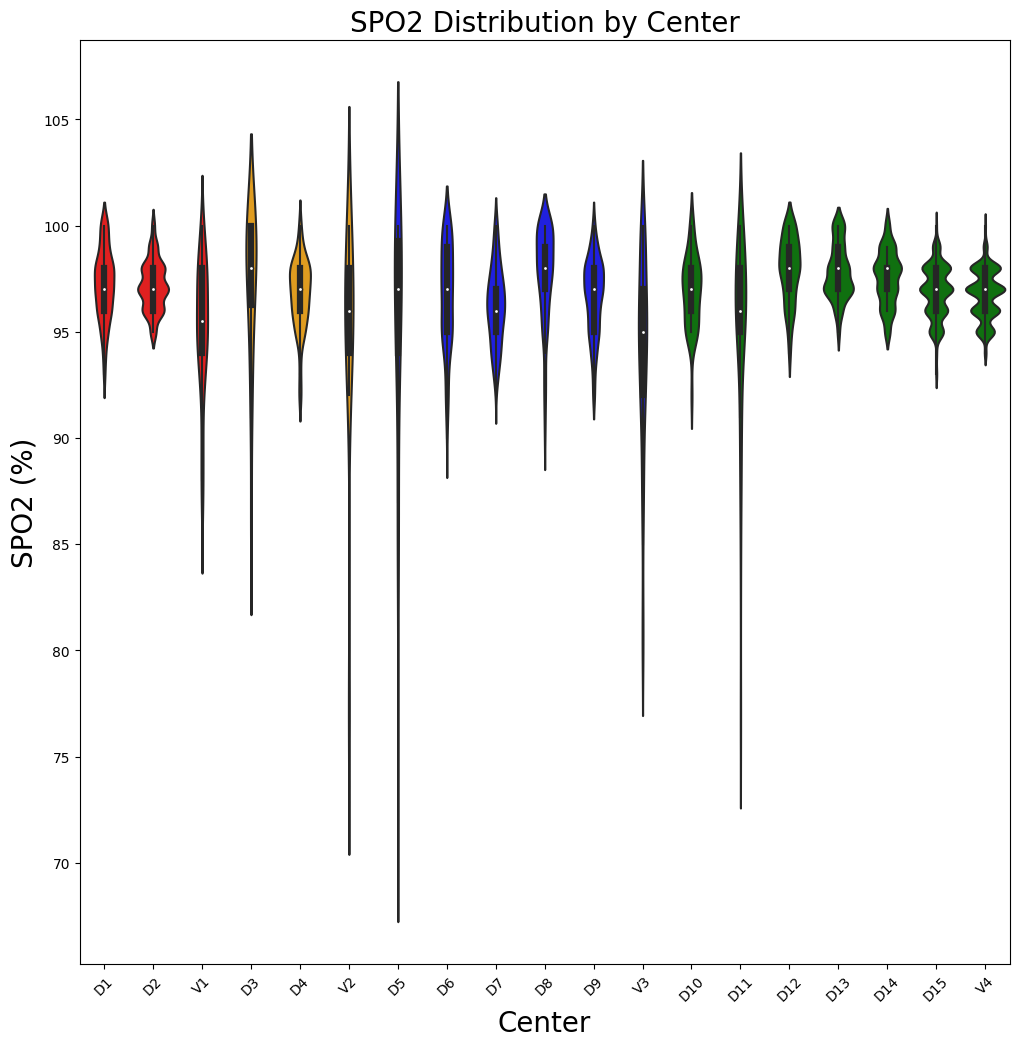

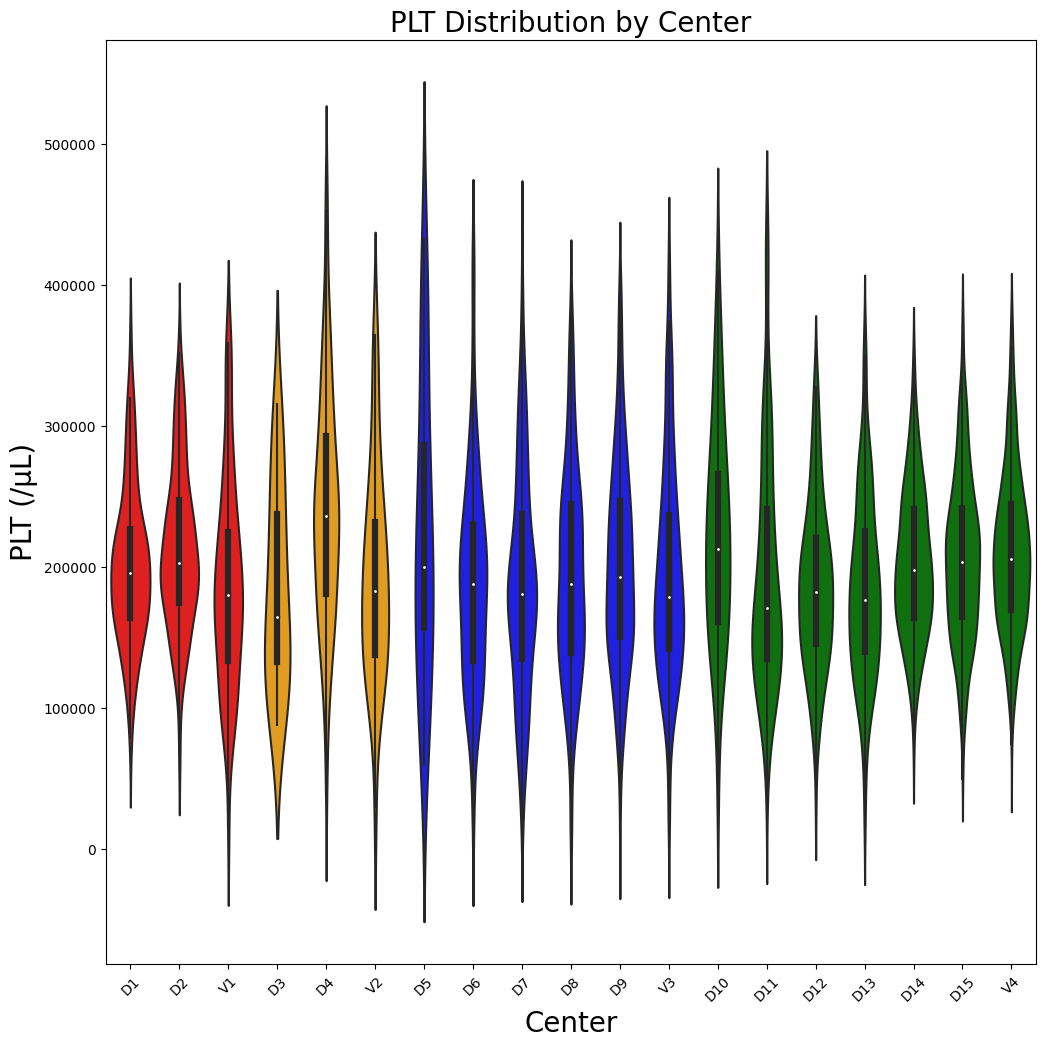

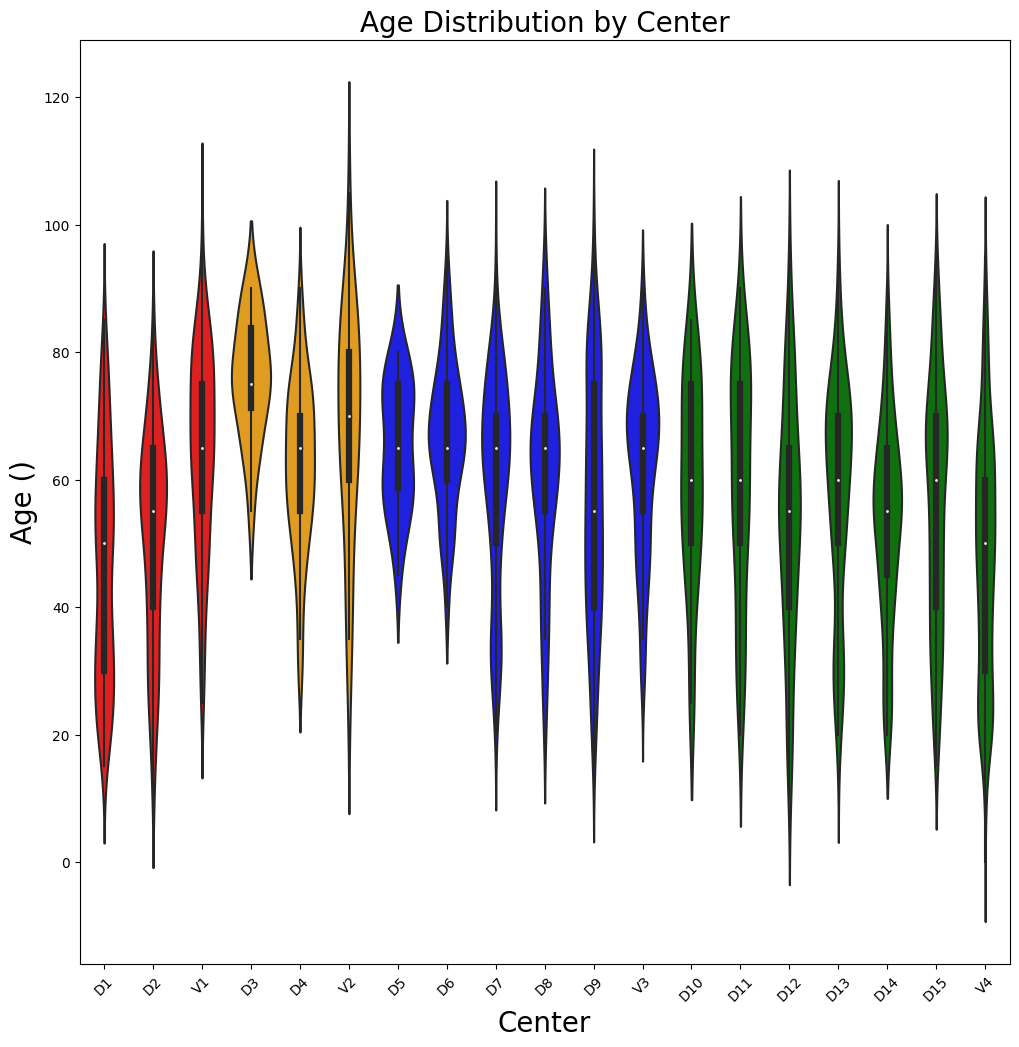

In [41]:
dataframes = [D1, D2, V1, D3, D4, V2, D5, D6, D7, D8, D9, V3, D10, D11, D12, D13, D14, D15, V4] 
labels = ['D1', 'D2', 'V1', 'D3', 'D4', 'V2', 'D5', 'D6', 'D7', 'D8', 'D9', 'V3', 'D10', 'D11','D12', 'D13', 'D14', 'D15', 'V4']
Variables_40 = ['CRP', 'LDH', 'ALC', 'ANC', 'RR', 'dyspnea', 'WBC', 'age', 'SPO2', 'PLT', 'DM']
continuous_variables = ['ANC', 'ALC', 'LDH', 'RR', 'WBC', 'CRP', 'SPO2', 'PLT', 'age']
categorical_variables = ['DM', 'dyspnea']
# Remove outliers from each DataFrame
dataframes_cleaned = [remove_outliers(df, continuous_variables) for df in dataframes]

# Then call the draw_violin_plots function with the cleaned dataframes
draw_violin_plots(dataframes_cleaned, labels, continuous_variables)

In [42]:
def draw_categorical_plots(dataframes, labels, important_variables):
    # Assign color to each center
    center_color_dict = {'D1': 'red', 'D2': 'red', 'V1': 'red',
                         'D3': 'orange', 'D4': 'orange', 'V2': 'orange',
                         'D5': 'blue', 'D6': 'blue', 'D7': 'blue', 'D8': 'blue', 'D9': 'blue', 'V3': 'blue',
                         'D10': 'green', 'D11': 'green', 'D12': 'green', 'D13': 'green', 'D14': 'green', 'D15': 'green', 'V4': 'green'}
    
    # Combine all the data into a single DataFrame with a new 'Center' column
    combined_df = pd.concat([df.assign(Center=label) for df, label in zip(dataframes, labels)])

    # Create bar plots for each important variable
    for variable in important_variables:
        # Calculate the proportion of positive cases
        proportions = combined_df.groupby(['Center', variable]).size().unstack().apply(lambda x: x / x.sum() * 100, axis=1).reset_index()

        plt.figure(figsize=(12, 12))
        ax = sns.barplot(x='Center', y=1, data=proportions, palette=center_color_dict, order=labels)
        variable_title = variable.capitalize() if variable in ['dyspnea', 'age'] else variable
        plt.title(f'{variable_title} Distribution by Center',size=20)
        plt.xlabel('Center', size=20)
        plt.ylabel('Proportion of Severe Cases (%)', size=20)
        plt.ylim(0,100)
        plt.xticks(rotation=45)
        # Update the legend labels
        legend_labels, _ = ax.get_legend_handles_labels()
        plt.savefig(f'../Result/{variable_title}_proportion_by_center.png', dpi=300)
        plt.show()

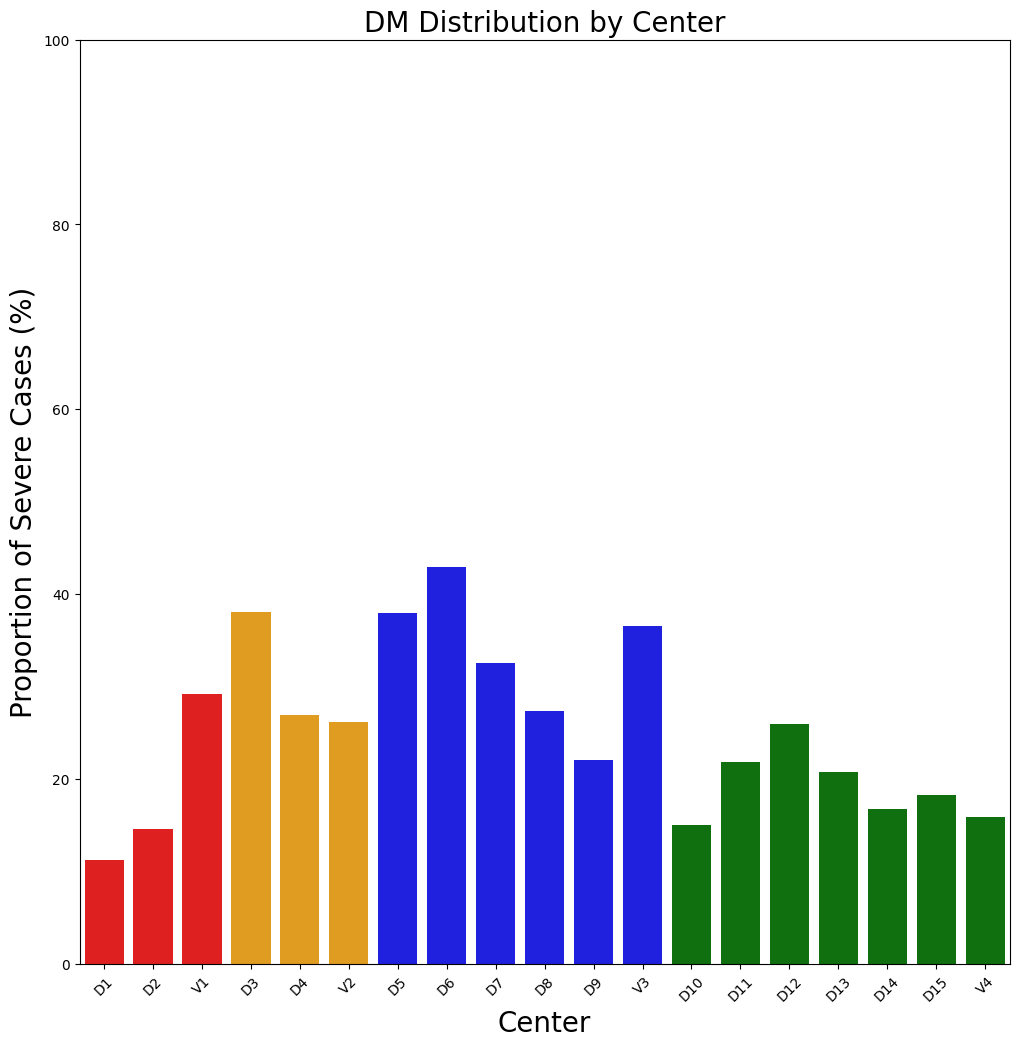

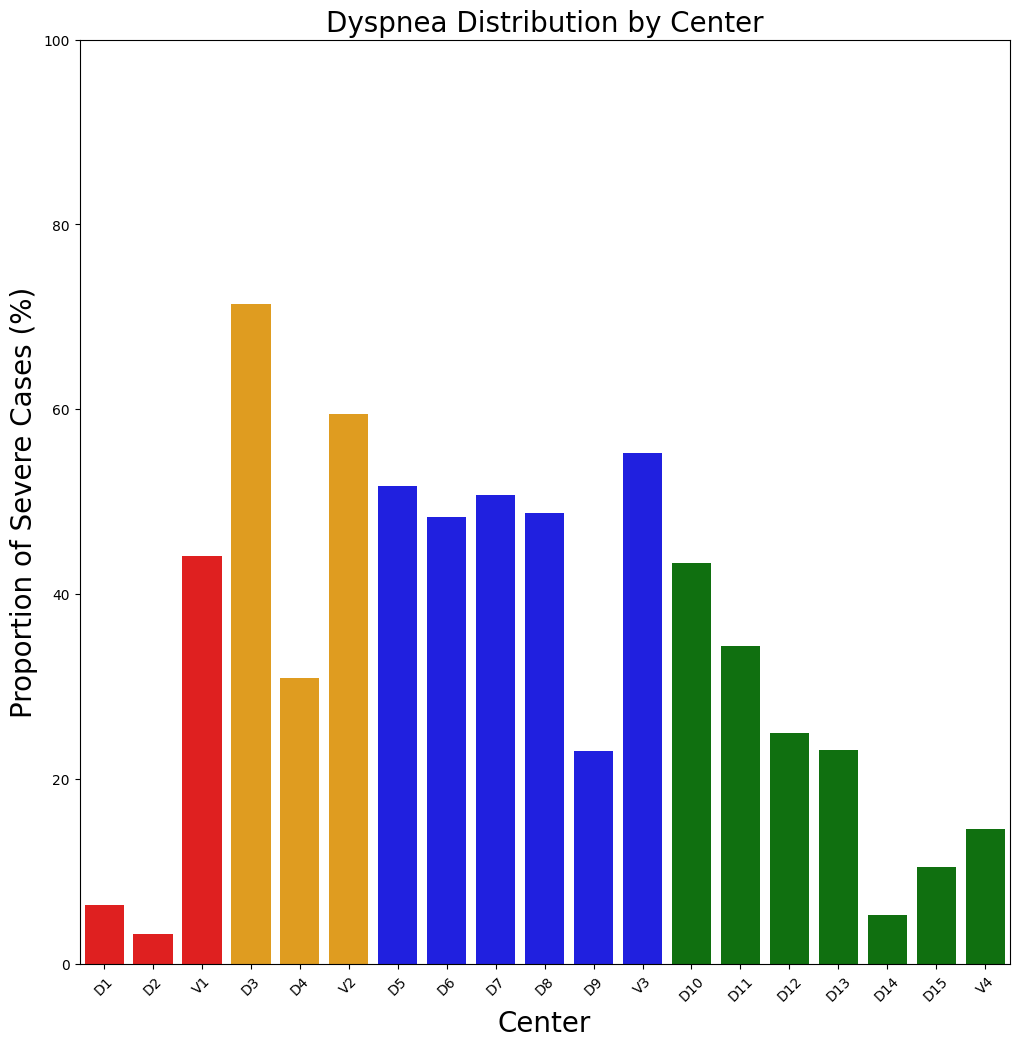

In [43]:
dataframes = [D1, D2, V1, D3, D4, V2, D5, D6, D7, D8, D9, V3, D10, D11, D12, D13, D14, D15, V4] 
labels = ['D1', 'D2', 'V1', 'D3', 'D4', 'V2', 'D5', 'D6', 'D7', 'D8', 'D9', 'V3', 'D10', 'D11','D12', 'D13', 'D14', 'D15', 'V4']
categorical_variables = ['DM', 'dyspnea']
draw_categorical_plots(dataframes, labels, categorical_variables)

### Odds Ratio Plot for Diagnosed Date

In [44]:
from pygam import LogisticGAM, s, f
from pygam.terms import TermList
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline


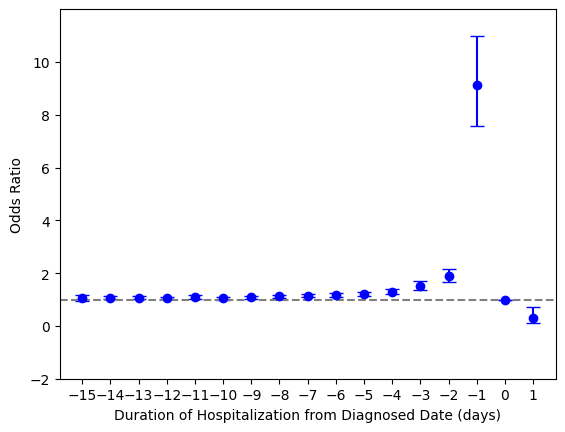

In [45]:
# Assuming df2 is your dataframe containing 'dx_date' and 'Severity' columns
OR_X = df2['dx_date']
OR_Y = df2['Severe']

# Initialize an empty DataFrame for the results
results_df = pd.DataFrame(columns=['dx_date', 'OR', 'CI_lower', 'CI_upper'])

# Loop through each day bin
for day in range(-15, 2):
    # Filter data for the current bin
    data_bin = df2[df2['dx_date'] == day]

    if data_bin.shape[0] == 0:
        continue

    # Create dummy variables for the 'dx_date' column
    X = data_bin['dx_date']
    y = data_bin['Severe']

    # Fit logistic regression model
    logit_model = sm.GLM(y, X, family=sm.families.Binomial())
    result = logit_model.fit()

    # Calculate Odds Ratios and Confidence Intervals
    OR = np.exp(result.params)
    CI = np.exp(result.conf_int()).values
    
    # Append results to the DataFrame
    temp_df = pd.DataFrame({'dx_date': [day], 'OR': [OR[0]], 'CI_lower': [CI[0][0]], 'CI_upper': [CI[0][1]]})
    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
# Specify title, ticks & labels of x-axis of OR plot
my_xname = "Duration of Hospitalization from Diagnosed Date (days)"
my_x_ticks = np.arange(-15, 2, 1)

# Specify title, range, ticks, labels of y-axis of OR plot
my_yname = "Odds Ratio"
my_y_ticks = np.arange(-2, 12, 2)

# Draw OR plot
fig, ax = plt.subplots()
ax.errorbar(results_df['dx_date'], results_df['OR'], yerr=[abs(results_df['OR'] - results_df['CI_lower']), abs(results_df['CI_upper'] - results_df['OR'])], fmt='o', capsize=5, color='blue')
ax.axhline(y=1, linestyle='--', color='gray')
ax.set_xlabel(my_xname)
ax.set_ylabel(my_yname)
ax.set_xticks(my_x_ticks)
ax.set_yticks(my_y_ticks)
ax.set_ylim(-2, 12)

# # Convert 'dx_date' and 'OR' columns to float data type
# results_df['dx_date'] = results_df['dx_date'].astype(float)
# results_df['OR'] = results_df['OR'].astype(float)

# # Interpolate the data points using cubic interpolation
# interpolated_func = interp1d(results_df['dx_date'], results_df['OR'], kind='quadratic', bounds_error=False)

# # Generate new x values for the interpolated curve
# x_new = np.linspace(results_df['dx_date'].min(), results_df['dx_date'].max(), num=1000)

# # Calculate the corresponding y values using the interpolated function
# y_new = interpolated_func(x_new)

# # Draw the smooth curve
# ax.plot(x_new, y_new, color='blue')

# Show the plot
plt.show()


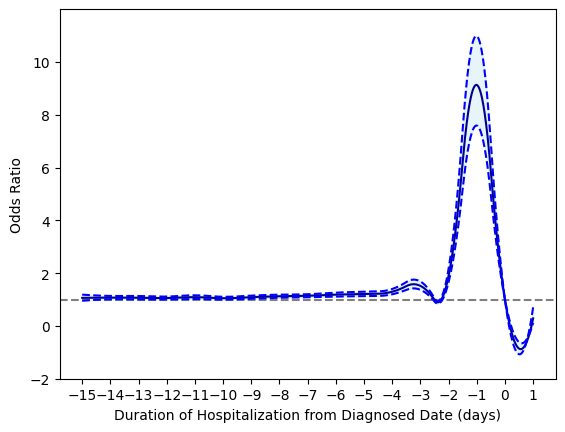

In [46]:
# Assuming df2 is your dataframe containing 'dx_date' and 'Severity' columns
OR_X = df2['dx_date']
OR_Y = df2['Severe']

# Initialize an empty DataFrame for the results
results_df = pd.DataFrame(columns=['dx_date', 'OR', 'CI_lower', 'CI_upper'])

# Loop through each day bin
for day in range(-15, 2):
    # Filter data for the current bin
    data_bin = df2[df2['dx_date'] == day]

    if data_bin.shape[0] == 0:
        continue

    # Create dummy variables for the 'dx_date' column
    X = data_bin['dx_date']
    y = data_bin['Severe']

    # Fit logistic regression model
    logit_model = sm.GLM(y, X, family=sm.families.Binomial())
    result = logit_model.fit()

    # Calculate Odds Ratios and Confidence Intervals
    OR = np.exp(result.params)
    CI = np.exp(result.conf_int()).values
    
    # Append results to the DataFrame
    temp_df = pd.DataFrame({'dx_date': [day], 'OR': [OR[0]], 'CI_lower': [CI[0][0]], 'CI_upper': [CI[0][1]]})
    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
# Specify title, ticks & labels of x-axis of OR plot
my_xname = "Duration of Hospitalization from Diagnosed Date (days)"
my_x_ticks = np.arange(-15, 2, 1)

# Specify title, range, ticks, labels of y-axis of OR plot
my_yname = "Odds Ratio"
my_y_ticks = np.arange(-2, 12, 2)

# Draw OR plot
fig, ax = plt.subplots()
# ax.errorbar(results_df['dx_date'], results_df['OR'], yerr=[abs(results_df['OR'] - results_df['CI_lower']), abs(results_df['CI_upper'] - results_df['OR'])], fmt='o', capsize=5, color='blue')
ax.axhline(y=1, linestyle='--', color='gray')
ax.set_xlabel(my_xname)
ax.set_ylabel(my_yname)
ax.set_xticks(my_x_ticks)
ax.set_yticks(my_y_ticks)
ax.set_ylim(-2, 12)

# Convert 'dx_date' and 'OR', 'CI_lower', 'CI_upper' columns to float data type
results_df['dx_date'] = results_df['dx_date'].astype(float)
results_df['OR'] = results_df['OR'].astype(float)
results_df['CI_lower'] = results_df['CI_lower'].astype(float)
results_df['CI_upper'] = results_df['CI_upper'].astype(float)

# Interpolate the data points using quadratic interpolation for OR, CI_lower, and CI_upper
interpolated_func_OR = interp1d(results_df['dx_date'], results_df['OR'], kind='quadratic', bounds_error=False)
interpolated_func_CI_lower = interp1d(results_df['dx_date'], results_df['CI_lower'], kind='quadratic', bounds_error=False)
interpolated_func_CI_upper = interp1d(results_df['dx_date'], results_df['CI_upper'], kind='quadratic', bounds_error=False)

# Generate new x values for the interpolated curve
x_new = np.linspace(results_df['dx_date'].min(), results_df['dx_date'].max(), num=1000)

# Calculate the corresponding y values using the interpolated function
y_new_OR = interpolated_func_OR(x_new)
y_new_CI_lower = interpolated_func_CI_lower(x_new)
y_new_CI_upper = interpolated_func_CI_upper(x_new)

# Draw the smooth curve for OR and the confidence intervals
ax.plot(x_new, y_new_OR, color='darkblue')
ax.plot(x_new, y_new_CI_lower, color='blue', linestyle='--')
ax.plot(x_new, y_new_CI_upper, color='blue', linestyle='--')

# Fill the area between the lower and upper confidence intervals
ax.fill_between(x_new, y_new_CI_lower, y_new_CI_upper, color='skyblue', alpha=0.2)

# Show the plot
plt.show()

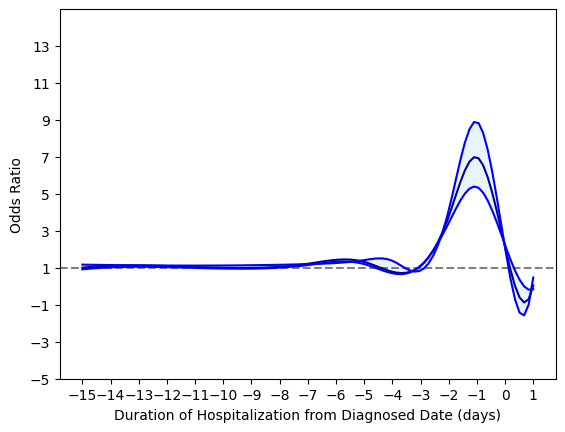

In [47]:
# Assuming df2 is your dataframe containing 'dx_date' and 'Severity' columns
OR_X = df2['dx_date']
OR_Y = df2['Severe']

# Initialize an empty DataFrame for the results
results_df = pd.DataFrame(columns=['dx_date', 'OR', 'CI_lower', 'CI_upper'])

# Loop through each day bin
for day in range(-15, 2):
    # Filter data for the current bin
    data_bin = df2[df2['dx_date'] == day]

    if data_bin.shape[0] == 0:
        continue

    # Create dummy variables for the 'dx_date' column
    X = data_bin['dx_date']
    y = data_bin['Severe']

    # Fit logistic regression model
    logit_model = sm.GLM(y, X, family=sm.families.Binomial())
    result = logit_model.fit()

    # Calculate Odds Ratios and Confidence Intervals
    OR = np.exp(result.params)
    CI = np.exp(result.conf_int()).values
    
    # Append results to the DataFrame
    temp_df = pd.DataFrame({'dx_date': [day], 'OR': [OR[0]], 'CI_lower': [CI[0][0]], 'CI_upper': [CI[0][1]]})
    results_df = pd.concat([results_df, temp_df], ignore_index=True)
    
# Specify title, ticks & labels of x-axis of OR plot
my_xname = "Duration of Hospitalization from Diagnosed Date (days)"
my_x_ticks = np.arange(-15, 2, 1)

# Specify title, range, ticks, labels of y-axis of OR plot
my_yname = "Odds Ratio"
my_y_ticks = np.arange(-5, 15, 2)

# Draw OR plot
fig, ax = plt.subplots()
# ax.errorbar(results_df['dx_date'], results_df['OR'], yerr=[abs(results_df['OR'] - results_df['CI_lower']), abs(results_df['CI_upper'] - results_df['OR'])], fmt='o', capsize=5, color='blue')
ax.axhline(y=1, linestyle='--', color='gray')
ax.set_xlabel(my_xname)
ax.set_ylabel(my_yname)
ax.set_xticks(my_x_ticks)
ax.set_yticks(my_y_ticks)
ax.set_ylim(-5, 15)

# Convert 'dx_date' and 'OR', 'CI_lower', 'CI_upper' columns to float data type
results_df['dx_date'] = results_df['dx_date'].astype(float)
results_df['OR'] = results_df['OR'].astype(float)
results_df['CI_lower'] = results_df['CI_lower'].astype(float)
results_df['CI_upper'] = results_df['CI_upper'].astype(float)

# Interpolate the data points using UnivariateSpline for OR, CI_lower, and CI_upper
spline_OR = UnivariateSpline(results_df['dx_date'], results_df['OR'], s=10)
spline_CI_lower = UnivariateSpline(results_df['dx_date'], results_df['CI_lower'], s=10)
spline_CI_upper = UnivariateSpline(results_df['dx_date'], results_df['CI_upper'], s=10)

# Generate new x values for the interpolated curve
x_new = np.linspace(results_df['dx_date'].min(), results_df['dx_date'].max(), num=100)

# Calculate the corresponding y values using the interpolated function
y_new_OR = spline_OR(x_new)
y_new_CI_lower = spline_CI_lower(x_new)
y_new_CI_upper = spline_CI_upper(x_new)

# Draw the smooth curve for OR and the confidence intervals
ax.plot(x_new, y_new_OR, color='darkblue')
ax.plot(x_new, y_new_CI_lower, color='blue', linestyle='-')
ax.plot(x_new, y_new_CI_upper, color='blue', linestyle='-')

# Fill the area between the lower and upper confidence intervals
ax.fill_between(x_new, y_new_CI_lower, y_new_CI_upper, color='skyblue', alpha=0.2)

# Show the plot
plt.show()

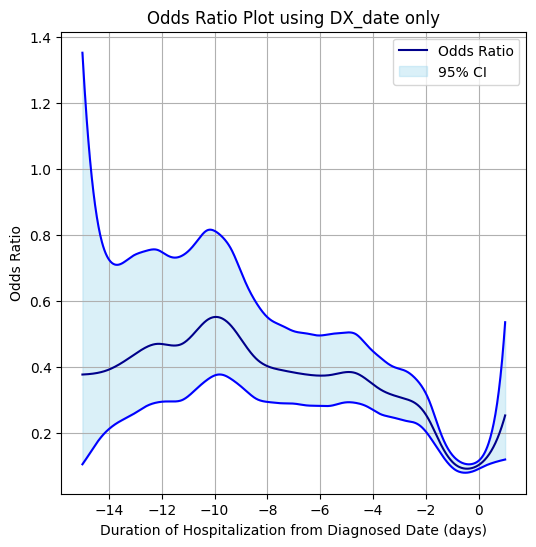

In [48]:
gam = LogisticGAM(s(0)).fit(OR_X, OR_Y)

# Generate a range of predictor values for plotting
x_range = np.linspace(OR_X.min(), OR_X.max(), 1000)

# Calculate the predicted probabilities and 95% confidence intervals
y_pred = gam.predict_proba(x_range)
y_intervals = gam.confidence_intervals(x_range, width=0.95)

# Convert probabilities to odds ratios
odds_pred = y_pred / (1 - y_pred)
odds_intervals = y_intervals / (1 - y_intervals)
odds_upper = odds_intervals[:, 1]
odds_lower = odds_intervals[:, 0]

# Plot the Odds Ratio curve with 95% confidence intervals
plt.figure(figsize=(6, 6))
plt.plot(x_range, odds_pred, label='Odds Ratio', color='darkblue')
plt.plot(x_range, odds_upper, linestyle='-', color='blue')
plt.plot(x_range, odds_lower, linestyle='-', color='blue')

# Fill the area between the curve and its 95% confidence interval with color
plt.fill_between(x_range, odds_upper, odds_lower, color='skyblue', alpha=0.3, label='95% CI')

plt.xlabel('Duration of Hospitalization from Diagnosed Date (days)')
plt.ylabel('Odds Ratio')
plt.title('Odds Ratio Plot using DX_date only')
plt.legend()
plt.grid()
plt.show()

In [49]:
Variables = ['dx_date', 'age', 'sex', 'HT', 'DM', 'CVD', 'cancer', 'other',
               'fever', 'cough', 'sputum', 'dyspnea', 'myalgia', 'sorethroat', 'mental', 'GI', 
               'BT', 'SBP', 'DBP', 'PR', 'RR', 'SPO2', 'WBC', 'ANC', 'ALC', 'PLT', 'CRP', 'LDH']

OR_X = df2[Variables]
OR_Y = df2.Severe

# Define the terms for the GAM model
term_list = []
for i, col in enumerate(OR_X.columns):
    if OR_X[col].dtype == 'object' or OR_X[col].nunique() < 10:
        term_list.append(f(i))  # Use factor term for categorical predictors
    else:
        term_list.append(s(i))  # Use spline term for continuous predictors

# Fit the multivariate GAM model
gam = LogisticGAM(TermList(*term_list)).fit(OR_X, OR_Y)

C:\Users\user\AppData\Roaming\Python\Python39\site-packages\pygam\links.py:151: RuntimeWarning: divide by zero encountered in divide
  return dist.levels / (mu * (dist.levels - mu))
C:\Users\user\AppData\Roaming\Python\Python39\site-packages\pygam\pygam.py:629: RuntimeWarning: invalid value encountered in multiply
  self.link.gradient(mu, self.distribution) ** 2


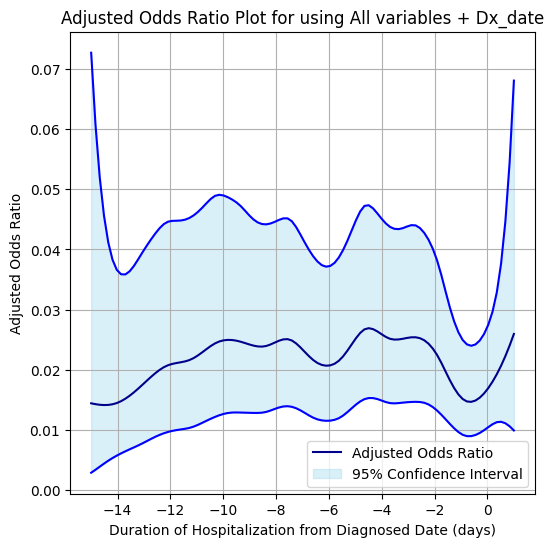

In [50]:
# Generate a range of dx_date values for plotting
dx_date_range = np.linspace(OR_X['dx_date'].min(), OR_X['dx_date'].max(), 100)

# Set other predictors to their median or mean values
predictor_values = {col: OR_X[col].median() if OR_X[col].dtype != 'object' else OR_X[col].median().iloc[0] for col in Variables[1:]}

# Prepare the input matrix for GAM prediction
X_pred = np.column_stack(([dx_date_range] + [np.full_like(dx_date_range, value) for value in predictor_values.values()]))

# Compute the predicted probabilities for the input matrix
y_pred = gam.predict_proba(X_pred)

# Calculate the odds ratio for each dx_date value
odds_pred = y_pred / (1 - y_pred)

# Compute the 95% confidence intervals for the predicted probabilities
conf_int = gam.confidence_intervals(X_pred, width=0.95)
y_lower = conf_int[:, 0]
y_upper = conf_int[:, 1]

# Convert the confidence intervals for probabilities into confidence intervals for odds ratios
odds_lower = y_lower / (1 - y_lower)
odds_upper = y_upper / (1 - y_upper)

# Plot the adjusted odds ratio and the confidence intervals
plt.figure(figsize=(6, 6))
plt.plot(dx_date_range, odds_pred, label='Adjusted Odds Ratio', color='darkblue')
plt.plot(dx_date_range, odds_upper, linestyle='-', color='blue')
plt.plot(dx_date_range, odds_lower, linestyle='-', color='blue')
plt.fill_between(dx_date_range, odds_lower, odds_upper, color='skyblue', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Duration of Hospitalization from Diagnosed Date (days)')
plt.ylabel('Adjusted Odds Ratio')
plt.title('Adjusted Odds Ratio Plot for using All variables + Dx_date')
plt.legend()
plt.grid()
plt.show()

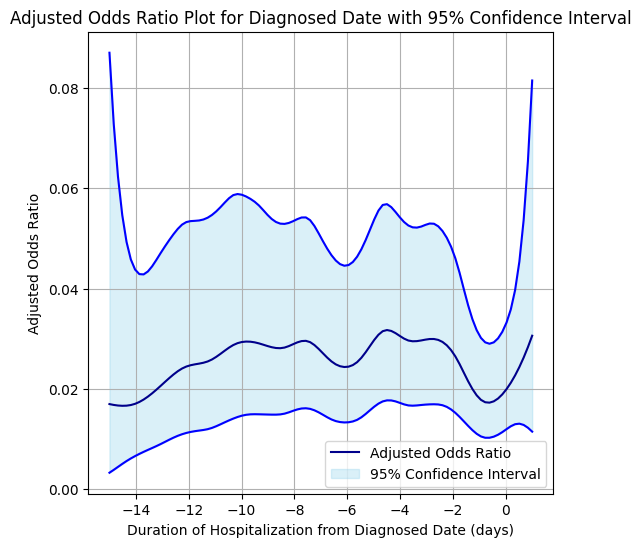

In [51]:
# Generate a range of dx_date values for plotting
dx_date_range = np.linspace(OR_X['dx_date'].min(), OR_X['dx_date'].max(), 100)

# Set other predictors to their median or mean values
predictor_values = {col: OR_X[col].mean() if OR_X[col].dtype != 'object' else OR_X[col].mean().iloc[0] for col in Variables[1:]}

# Prepare the input matrix for GAM prediction
X_pred = np.column_stack(([dx_date_range] + [np.full_like(dx_date_range, value) for value in predictor_values.values()]))

# Compute the predicted probabilities for the input matrix
y_pred = gam.predict_proba(X_pred)

# Calculate the odds ratio for each dx_date value
odds_pred = y_pred / (1 - y_pred)

# Compute the 95% confidence intervals for the predicted probabilities
conf_int = gam.confidence_intervals(X_pred, width=0.95)
y_lower = conf_int[:, 0]
y_upper = conf_int[:, 1]

# Convert the confidence intervals for probabilities into confidence intervals for odds ratios
odds_lower = y_lower / (1 - y_lower)
odds_upper = y_upper / (1 - y_upper)

# Plot the adjusted odds ratio and the confidence intervals
plt.figure(figsize=(6, 6))
plt.plot(dx_date_range, odds_pred, label='Adjusted Odds Ratio', color='darkblue')
plt.plot(dx_date_range, odds_upper, linestyle='-', color='blue')
plt.plot(dx_date_range, odds_lower, linestyle='-', color='blue')
plt.fill_between(dx_date_range, odds_lower, odds_upper, color='skyblue', alpha=0.3, label='95% Confidence Interval')

plt.xlabel('Duration of Hospitalization from Diagnosed Date (days)')
plt.ylabel('Adjusted Odds Ratio')
plt.title('Adjusted Odds Ratio Plot for Diagnosed Date with 95% Confidence Interval')
plt.legend()
plt.grid()
plt.show()